In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from utils.functions.func_plot_graphs import plot_graphs
from utils.functions.func_fix_date_format import fix_dates 
from utils.functions.func_fix_column_names import snake_case
from utils.functions.func_helper_print_colors import color_print
from utils.functions.func_helper_query_dataset import query_dataframe
from utils.functions.func_helper_duplicate_rows import print_duplicate_rows
from utils.functions.func_helper_convert_date_format import convert_date_format

In [2]:
# Loading dataset config CSV
base_path = os.getcwd()
config_path = os.path.join(base_path, "utils", "configs", "datasets_config.csv")
datasets_df = pd.read_csv(config_path)

# Convert CSV config into dictionary with full paths
dataset_paths = {
    row['name']: os.path.normpath(os.path.join(base_path, row['path']))
    for _, row in datasets_df.iterrows()
}

solarData_path = dataset_paths.get('solarData')
solarData = pd.read_csv(solarData_path, encoding='ISO-8859-1')

In [3]:
query_dataframe(solarData, filepath=solarData_path, encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\00.ExamProject\data\Teague_Table.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 6902
        Rows loaded in DataFrame: 3450
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (3450, 8)
                                                
                                                
                                                

   Missing values per column:
                                                
Date                                                              89
No.                                                              473
N / S                                                            473
C / Rn                                                          2031
C / Rs                                                      

In [4]:
solarData['Date']

0        9 Nov 1853
1       17 Nov 1853
2       17 Nov 1853
3       21 Nov 1853
4       23 Nov 1853
           ...     
3445    24 Mar 1861
3446    24 Mar 1861
3447    24 Mar 1861
3448    24 Mar 1861
3449            NaN
Name: Date, Length: 3450, dtype: object

# After initial check what we see is that some of the columns and data that they hold need to be changed in some 
# convinient for our work way
# Fist off -> dates are in format that needs to changed, we will use %Y-%m-%d
# we will call custom made function 'fix_dates' for that
# we can keep original datate in 'Date_original', although it is not necesarry

In [5]:
solarData['Date_original'] = solarData['Date']

In [6]:
solarData['Date_original']

0        9 Nov 1853
1       17 Nov 1853
2       17 Nov 1853
3       21 Nov 1853
4       23 Nov 1853
           ...     
3445    24 Mar 1861
3446    24 Mar 1861
3447    24 Mar 1861
3448    24 Mar 1861
3449            NaN
Name: Date_original, Length: 3450, dtype: object

In [7]:
solarData = fix_dates(solarData, 'Date')

# Next thing that we see and needs to be fixed are the names of the column.

In [8]:
solarData.columns

Index(['Date', 'No.', 'N / S', 'C / Rn', 'C / Rs', 'C / R', 'Wolf',
       '                                                       Notes',
       'Date_original', 'invalid_date'],
      dtype='object')

# we will convert them in lower case, snake_case model
# another function that will do this for us 'snake_case'
# solarData.columns.map(snake_case)

In [9]:
solarData_original_column_names = solarData.columns.copy()

In [10]:
solarData_original_column_names

Index(['Date', 'No.', 'N / S', 'C / Rn', 'C / Rs', 'C / R', 'Wolf',
       '                                                       Notes',
       'Date_original', 'invalid_date'],
      dtype='object')

In [11]:
solarData.columns = solarData.columns.map(snake_case)

In [12]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [13]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

# now we have our columns renamed in the way we want 

# next thing is to work out column types.
# on the first look most of the columns have 'object' as a type.
# this must be changed before we start trying to fecth any meaningfull information from our dataset

In [14]:
solarData.dtypes

date              object
no                object
n_s               object
c_rn              object
c_rs              object
c_r               object
wolf             float64
notes             object
date_original     object
invalid_date        bool
dtype: object

In [15]:
cols = list(solarData.columns)
for i in range(0, len(cols), 5):
    print(cols[i:i+5])

['date', 'no', 'n_s', 'c_rn', 'c_rs']
['c_r', 'wolf', 'notes', 'date_original', 'invalid_date']


In [16]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,NaN,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,NaN,NaN,NaN,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,NaN,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,NaN,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,NaN,12,12,38.0,NaN,23 Nov 1853,False


# First column that we will work on is 'n_s'
# this is most likly related to which SUN's hemisphere is data for, norther on souther
# this means that column is cathegorical we can convert this column to type 'category'

In [17]:
solarData['n_s'] = solarData['n_s'].astype('category')

In [18]:
solarData.dtypes

date               object
no                 object
n_s              category
c_rn               object
c_rs               object
c_r                object
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object

# Now that we have 'n_s' column with type 'category' we should take care of NaN's that we have as a data

In [19]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,NaN,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,NaN,NaN,NaN,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,NaN,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,NaN,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,NaN,12,12,38.0,NaN,23 Nov 1853,False


# If we drop all NaN we might loose valuable data
# for this particular dataset which hold Solar activity data, probably NaN means there were  no data recorded
# which most likely means that we can just replace NaN's with zeroes.
# this wont bring any unpleasant deviation in future data stats
# also keeping NaN's, replaced with zeroes means we keep all other data

# тук ще направи провверка преди замяната на NaN's след като сме ги заменили.. mind bending time travel ....

In [20]:
cols = ['c_rn','c_rs','c_r','wolf']
print(solarData[cols].eq(0).sum())

c_rn      0
c_rs      0
c_r       0
wolf    379
dtype: int64


# and now we prove ourselves that 'wolf' had zeroes before we converted all NaN's to zeroes.

# First we will collect some initial info as total counts of NaNs and so on ..

In [21]:
solarData['date'] = pd.to_datetime(solarData['date'], errors='coerce')

print("Earliest date:", solarData['date'].min())
print("Latest date:", solarData['date'].max())
print("Available years sample:", solarData['date'].dt.year.dropna().unique()[:20])

Earliest date: 1853-11-09 00:00:00
Latest date: 1861-03-24 00:00:00
Available years sample: [1853. 1854. 1855. 1856. 1857. 1858. 1859. 1860. 1861.]


In [22]:
numeric_columns = [
    'no',
    'c_rn',
    'c_rs',
    'c_r',
    'wolf'
]

solarData[numeric_columns] = solarData[numeric_columns].fillna(0)
    

In [23]:

nan_counts_before = solarData[numeric_columns].isna().sum()
zero_counts_before = (solarData[numeric_columns] == 0).sum()

print("NaNs before replacement:\n", nan_counts_before)
print("Zeros before replacement:\n", zero_counts_before)

NaNs before replacement:
 no      0
c_rn    0
c_rs    0
c_r     0
wolf    0
dtype: int64
Zeros before replacement:
 no       473
c_rn    2031
c_rs    1816
c_r     2211
wolf    2590
dtype: int64


# So now we can convert it

In [24]:
numeric_columns = [
    'no',
    'c_rn',
    'c_rs',
    'c_r',
    'wolf'
]

solarData[numeric_columns] = solarData[numeric_columns].fillna(0)

# Lets check if there are so leftover NaN's in our numeric columns

In [25]:
check_NaNs = solarData[numeric_columns].isna().sum()
print(check_NaNs)

no      0
c_rn    0
c_rs    0
c_r     0
wolf    0
dtype: int64


# And to check if NaN's are zerow now

In [26]:
zero_check = (solarData[numeric_columns] == 0).sum()
print(zero_check)

no       473
c_rn    2031
c_rs    1816
c_r     2211
wolf    2590
dtype: int64


# We have initial dataset check in the very begining of our dataset observation.
# we called 'query_dataframe(solarData, filepath=solarData_path, encoding='ISO-8859-1')'
# and the results were:

Missing values per column:
                                                
Date               89
No.                473
N / S              473
C / Rn             2031
C / Rs             1816
C / R              2211
Wolf               2211
Notes              2854


# what we can see is that most of the data mathes, with one exception -> the column 'wolf',
# which after we replaced NaN's with zeroes, now holds more zeroes than in the beginning
# this means that this column had zeroes befor that
# We can check that if we go back before replacing 'NaN's' with zeroes and do some additional checks

# up above in cell 20 we have cheked that 'wolf' contained 379 zeroes before we did NaN's to zero replacement
'wolf    379'


# so wo calculate the difference (0 to NaN's) .. 2211+379 = 2590
# looks like everythong is correnct -> initial zeroes + converted NaN's equals exactly what we have now

# we can continue with columns's type correction 

In [27]:
print(solarData.dtypes)

date             datetime64[ns]
no                       object
n_s                    category
c_rn                     object
c_rs                     object
c_r                      object
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object


In [28]:
print(solarData.isnull().sum())

date               99
no                  0
n_s               473
c_rn                0
c_rs                0
c_r                 0
wolf                0
notes            2854
date_original      89
invalid_date        0
dtype: int64


In [29]:
print(solarData.describe(include='all'))

                                 date      no   n_s    c_rn    c_rs     c_r  \
count                            3351  3450.0  2977  3450.0  3450.0  3450.0   
unique                            NaN   948.0     2    41.0    51.0   152.0   
top                               NaN     0.0     S     0.0     0.0     0.0   
freq                              NaN   473.0  1596  2031.0  1816.0  2211.0   
mean    1858-09-21 18:56:36.956131840     NaN   NaN     NaN     NaN     NaN   
min               1853-11-09 00:00:00     NaN   NaN     NaN     NaN     NaN   
25%               1857-06-02 00:00:00     NaN   NaN     NaN     NaN     NaN   
50%               1859-05-08 00:00:00     NaN   NaN     NaN     NaN     NaN   
75%               1860-06-25 00:00:00     NaN   NaN     NaN     NaN     NaN   
max               1861-03-24 00:00:00     NaN   NaN     NaN     NaN     NaN   
std                               NaN     NaN   NaN     NaN     NaN     NaN   

               wolf              notes date_origina

In [30]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False


In [31]:
print(solarData.dtypes)

date             datetime64[ns]
no                       object
n_s                    category
c_rn                     object
c_rs                     object
c_r                      object
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object


# We have columns containing numbers, but have 'object' set as type, which can be seen in above few cells
# we can see that based on that .describe() did not calculate all cells correct because of type 'object'
# assigned on numeric columns
# according to spacifications even if we have 0 in a column or cell .describe() will show it as s Nan if
# the column type is set to 'object', and .describe() will treat it column as categorical

# we will convert column types to numeric

In [32]:
numeric_int_cols = ['no', 'c_rn', 'c_rs', 'c_r']
for col in numeric_int_cols:
    solarData[col] = pd.to_numeric(solarData[col], errors='coerce').astype('Int64')

In [33]:
print(solarData.dtypes)

date             datetime64[ns]
no                        Int64
n_s                    category
c_rn                      Int64
c_rs                      Int64
c_r                       Int64
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object


# now our columns lloks like having correct data types

# lets try .describe() again to see f there are differences in presenting data

In [34]:
print(solarData.describe(include='all'))

                                 date          no   n_s      c_rn      c_rs  \
count                            3351      3393.0  2977    3441.0    3447.0   
unique                            NaN        <NA>     2      <NA>      <NA>   
top                               NaN        <NA>     S      <NA>      <NA>   
freq                              NaN        <NA>  1596      <NA>      <NA>   
mean    1858-09-21 18:56:36.956131840  431.480106   NaN  6.176983  7.291268   
min               1853-11-09 00:00:00         0.0   NaN       0.0       0.0   
25%               1857-06-02 00:00:00       130.0   NaN       0.0       0.0   
50%               1859-05-08 00:00:00       414.0   NaN       0.0       0.0   
75%               1860-06-25 00:00:00       745.0   NaN      12.0      12.0   
max               1861-03-24 00:00:00       954.0   NaN      59.0      67.0   
std                               NaN  322.855426   NaN  8.561053  9.345027   

              c_r         wolf              notes d

# looks like we are good to go

In [35]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [36]:
solarData.dtypes

date             datetime64[ns]
no                        Int64
n_s                    category
c_rn                      Int64
c_rs                      Int64
c_r                       Int64
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object

In [37]:
solarData.head(10)

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False
5,1853-11-25,3,S,0,11,0,0.0,NaN,25 Nov 1853,False
6,1853-11-25,4,N,11,0,22,36.0,NaN,25 Nov 1853,False
7,NaT,0,NaN,0,0,0,0.0,"Rn = 11.6, Rs = 4.6, R = 16.2.",NaN,True
8,1853-12-01,5,S,0,13,13,14.0,NaN,1 Dec 1853,False
9,1853-12-02,5,S,0,12,0,0.0,NaN,2 Dec 1853,False


In [38]:
solarData['date']

0      1853-11-09
1      1853-11-17
2      1853-11-17
3      1853-11-21
4      1853-11-23
          ...    
3445   1861-03-24
3446   1861-03-24
3447   1861-03-24
3448   1861-03-24
3449          NaT
Name: date, Length: 3450, dtype: datetime64[ns]

solarData_dateColumn_fixed_dates = solarData = fix_dates(solarData, 'date')

solarData_dateColumn_original_dates = solarData.columns.copy()

In [39]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False


# now thet we have our coluns, column's type and data in there corrected, we can try to pull out some
# meaningfull stats

# we can assing a variable with our numeric columns that we will use

In [40]:
numerical_columns = ['no', 'c_rn', 'c_rs', 'c_r', 'wolf']

# it will probably be a good idia to explain which solumn what data hold for
# or what the column names mean
# data is fetched as a cvs file from https://sidc.be/SILSO/home
# and contains information and observation for statistics related to solar activity, 
# solar sports, groups taht are formed by those spots, information for each hemispere activity and so on ..
no    →   observation (последователност на наблюденията за дадена дата).
n_s   →   sun's hemisphere, N or S (north or south hemisphere).
c_rn  →   number of sun's spots group in norther hemisphere.
c_rs  →   number of sun's spots group in southern hemisphere.
c_r   →   total number of sum spots groups (most likely sum of c_rn and c_rs).
wolf  →   Wolf number.
notes →   notes related to each observation.
date  →   date of observation.

In [41]:
correlation_matrix = solarData[numeric_columns].corr()
print(correlation_matrix)

            no      c_rn      c_rs       c_r      wolf
no    1.000000  0.222134  0.158107  0.114561  0.086972
c_rn  0.222134  1.000000 -0.564677  0.076566  0.071182
c_rs  0.158107 -0.564677  1.000000  0.008699 -0.006061
c_r   0.114561  0.076566  0.008699  1.000000  0.963700
wolf  0.086972  0.071182 -0.006061  0.963700  1.000000


# here we have calculated correlation matrix
c_r и wolf → 0.96 корелация
Изключително висока и очаквана — числото на Wolf се изчислява частично на базата на броя на групите слънчеви петна (и отделните петна), така че c_r и wolf се движат почти еднакво.

c_rn и c_rs → -0.56 корелация
Умерено силна отрицателна корелация — когато има повече групи в Северното полукълбо, обикновено има по-малко в Южното, и обратно. Това вероятно се дължи на фазови измествания в активността между полукълбата на Слънцето.

no спрямо другите (0.08–0.22)
Много слаби корелации — no е просто пореден номер на наблюдението за дадена дата, така че няма силна връзка със самите нива на слънчева активност.

Останалите стойности са близо до 0
Това означава, че има малка или никаква линейна зависимост между съответните двойки променливи. 

In [42]:
correlation_matrix = solarData[numeric_columns].corr()
print(correlation_matrix)

            no      c_rn      c_rs       c_r      wolf
no    1.000000  0.222134  0.158107  0.114561  0.086972
c_rn  0.222134  1.000000 -0.564677  0.076566  0.071182
c_rs  0.158107 -0.564677  1.000000  0.008699 -0.006061
c_r   0.114561  0.076566  0.008699  1.000000  0.963700
wolf  0.086972  0.071182 -0.006061  0.963700  1.000000


# we see some negative values which might be related to the fact that 
# usualy one hemisphere is active and the other is not active..
# we can try to aggregate by date first, and then to try correlation between columns


In [43]:
daily = (solarData.groupby('date')[['c_rn','c_rs','c_r','wolf']]
         .agg({'c_rn':'sum','c_rs':'sum','c_r':'sum','wolf':'mean'}))

corr_daily = daily[['c_rn','c_rs','c_r','wolf']].corr()
print(corr_daily)

          c_rn      c_rs       c_r      wolf
c_rn  1.000000  0.552949  0.866320  0.361247
c_rs  0.552949  1.000000  0.890705  0.420452
c_r   0.866320  0.890705  1.000000  0.446935
wolf  0.361247  0.420452  0.446935  1.000000


# as we can see aggregating changes correlation values 
# also column 'no' is removed from matrix as it is just an observation id and it brings no meaninful relation
# between

# based on that correlation 
# we can visualy present heat map which will show this correlation between each 

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\2328453837.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  heat = (daily.resample('M')


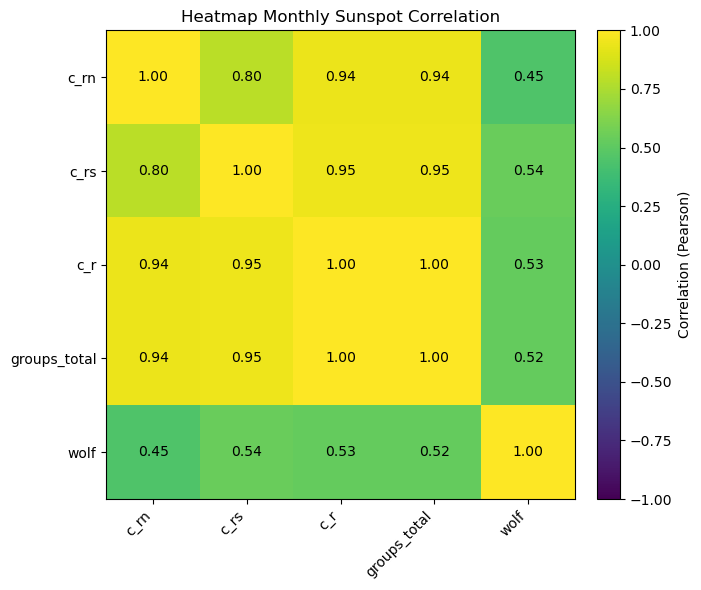

In [44]:
df = (solarData_fullDataSet.copy()
      if 'solarData_fullDataSet' in globals() else solarData.copy())
if 'date' not in df.columns:
    if 'date_original' in df.columns:
        df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
    else:
        raise KeyError("No 'date' column found.")
else:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# total groups and choose wolf column
df['groups_total'] = df[['c_rn','c_rs']].fillna(0).sum(axis=1)
wolf_col = 'wolf_corrected' if 'wolf_corrected' in df.columns else 'wolf'

# just one row per day (counts=sum, wolf=mean)
daily = (df.groupby('date')
           .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
                c_rs=('c_rs', lambda s: s.sum(min_count=1)),
                c_r =('c_r',  lambda s: s.sum(min_count=1)),
                wolf=(wolf_col, 'mean')))
daily['groups_total'] = daily[['c_rn','c_rs']].fillna(0).sum(axis=1)

# aggregating by month for the heatmap (counts=sum, wolf=mean)
heat = (daily.resample('M')
             .agg({'c_rn':'sum', 'c_rs':'sum', 'c_r':'sum',
                   'groups_total':'sum', 'wolf':'mean'})
             .dropna(how='all'))

# Correlation + plot
corr = heat.corr()
labels = corr.columns.tolist()

fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right'); ax.set_yticklabels(labels)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation (Pearson)')

for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center')

ax.set_title('Heatmap Monthly Sunspot Correlation')
plt.tight_layout()
plt.savefig('Heatmap_Sunspot.jpg', dpi=300)
plt.show()

# lets break down the table with explanation:

total spots ('c_r') with total groups -> 0.94, 0.95 wich is almost 1, which is almost perfect linear 
so spots per group ration stable month to month

'c_rn' with 'c_rs' -> 0.80, good correlation between both hemispheres during the sun cycle,
but we can also say thet there is a some kind of hemisphere assymetry.

'Wolf number' with sun's spot counts -> 0.45 - 0.54, this is kind of weird, it is much smaller than 
count's correlation

# It is very unlikly that the data in 'wolf' column is correct in therms of
# method in which wolf number is calculated.
# In theory according to Astrophysics books wolf number is calculated by the 
# W = k*(10 * g + f). here 'g' is groups countand 'f' is the sports count
# So, following formula: W = k*(10 * spots'groups + spots).
# k is constant that Astrophysists set as 1, so it has no impact 
# but as the data in the dataset, we can see that counts are very small
# So they might be calculated by some old method which is just W = (g+s)

# We can seee the differences in hwat we have and what we expect to have according to the recent formula 
# for 'Wolf' number

In [45]:
solarData['wolf_expected'] = 10 * (solarData['c_rn'].fillna(0) + 
                                   solarData['c_rs'].fillna(0)) + \
                             solarData['c_r'].fillna(0)

solarData['wolf_diff'] = solarData['wolf'] - solarData['wolf_expected']

In [46]:
print(solarData[['date','no','c_rn','c_rs','c_r','wolf','wolf_expected','wolf_diff']].head(20))
print(solarData['wolf_diff'].describe())

         date  no  c_rn  c_rs  c_r  wolf  wolf_expected  wolf_diff
0  1853-11-09   1    11     0   11  22.0            121      -99.0
1  1853-11-17   1    11     0    0   0.0            110     -110.0
2  1853-11-17   2    11     0   22  28.0            132     -104.0
3  1853-11-21   2    14     0   14  20.0            154     -134.0
4  1853-11-23   3     0    12   12  38.0            132      -94.0
5  1853-11-25   3     0    11    0   0.0            110     -110.0
6  1853-11-25   4    11     0   22  36.0            132      -96.0
7         NaT   0     0     0    0   0.0              0        0.0
8  1853-12-01   5     0    13   13  14.0            143     -129.0
9  1853-12-02   5     0    12    0   0.0            120     -120.0
10 1853-12-02   6     0    11   23  12.0            133     -121.0
11 1853-12-08   6     0    15    0   0.0            150     -150.0
12 1853-12-08   7    13     0   28  24.0            158     -134.0
13 1853-12-09   6     0    11    0   0.0            110     -1

# as we can see there is a signifficant difference bettwen the numbers we have and 
# the numbewrs we expect. So in the dataset 'wolf' is just the sum of sports and groups.

# We can try to manipulate readings and to calculate Wolf as recent formula suggests
# and after that we can compare correlation matrix and heat maps for both old and 'new' Wolf numbers
# this way we can see if there is significant difference in readings

In [47]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff'],
      dtype='object')

# we will group all rows which have same date, and for each day we calculate sums for
# each individual 'c_rn', 'c_rs' and 'c_r'

In [48]:
wolf_daily = (solarData.groupby('date')
                       .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
                            c_rs=('c_rs', lambda s: s.sum(min_count=1)),
                            c_r=('c_r', lambda s: s.sum(min_count=1)))
             )

# we will calculate deily totals and Wolf number with recent formula for that day
# we sum up sount and north groups per day, and if there is no data wi fill NaN's with 0
wolf_daily['groups_total'] = daily[['c_rn', 'c_rs']].fillna(0).sum(axis=1)
wolf_daily['wolf_recent'] = 10 * wolf_daily['groups_total'].fillna(0) + daily['c_r'].fillna(0)


# we will agregate so we can plot heat map after that 
# summing all counts, and taking mean for Wolf, we are comparing month mean for Wolf, not sum
wolf_monthly = (wolf_daily.resample('M')
                .agg({'c_rn':'sum',
                     'c_rs':'sum',
                     'c_r':'sum',
                     'groups_total':'sum',
                     'wolf_recent':'mean'})
                .dropna(how='all'))

collumns = ['c_rn', 'c_rs', 'c_r', 'groups_total', 'wolf_recent']
correlation_matrix_wolf_recent = wolf_monthly[collumns].corr()
print(f"Correlation matrix for Wolf nimber calculated with recent formula: \n")
print(correlation_matrix_wolf_recent.round(3))

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\3271196940.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wolf_monthly = (wolf_daily.resample('M')


Correlation matrix for Wolf nimber calculated with recent formula: 

               c_rn   c_rs    c_r  groups_total  wolf_recent
c_rn          1.000  0.796  0.944         0.944        0.750
c_rs          0.796  1.000  0.951         0.951        0.774
c_r           0.944  0.951  1.000         1.000        0.802
groups_total  0.944  0.951  1.000         1.000        0.804
wolf_recent   0.750  0.774  0.802         0.804        1.000


# lets see again the old correlation matrix, for comparison

In [49]:
daily = (solarData.groupby('date')[['c_rn','c_rs','c_r','wolf']]
         .agg({'c_rn':'sum','c_rs':'sum','c_r':'sum','wolf':'mean'}))

corr_daily = daily[['c_rn','c_rs','c_r','wolf']].corr()
print(corr_daily)

          c_rn      c_rs       c_r      wolf
c_rn  1.000000  0.552949  0.866320  0.361247
c_rs  0.552949  1.000000  0.890705  0.420452
c_r   0.866320  0.890705  1.000000  0.446935
wolf  0.361247  0.420452  0.446935  1.000000


# as we can see there are differences for wolf numners corelated to other counts

# lets plot new heat map

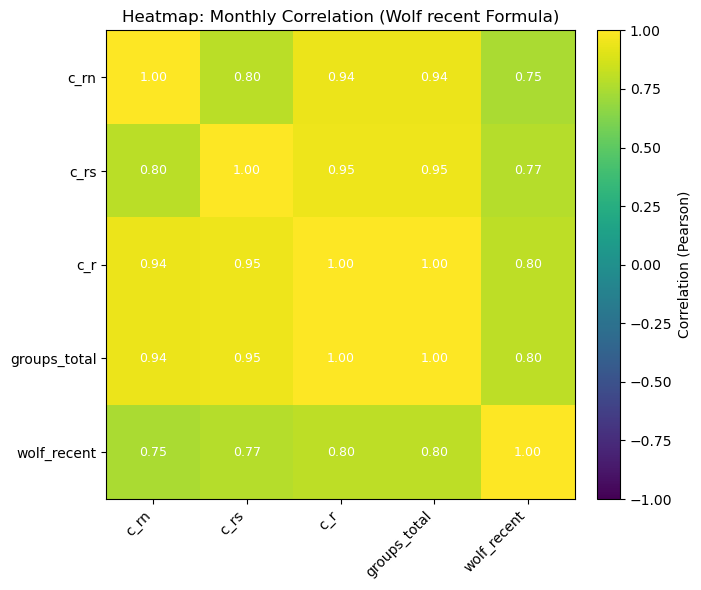

In [50]:
fig, ax = plt.subplots(figsize=(7,6))
labels = correlation_matrix_wolf_recent.columns.tolist()
im = ax.imshow(correlation_matrix_wolf_recent.values, vmin=-1, vmax=1, cmap='viridis')
ax.set_xticks(np.arange(len(labels))); ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right'); ax.set_yticklabels(labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        v = correlation_matrix_wolf_recent.values[i, j]
        ax.text(j, i, f"{v:.2f}", ha='center', va='center',
                color=('w' if abs(v) > 0.6 else 'k'), fontsize=9)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation (Pearson)')
ax.set_title('Heatmap: Monthly Correlation (Wolf recent Formula)')
plt.tight_layout()
plt.savefig('Heatmap_Sunspot_Wolf_recent.jpg', dpi=300)
plt.show()

# let try to compare both heat maps side by side
# for easier reading 

In [51]:
wolf_daily = (solarData.groupby('date')
                       .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
                            c_rs=('c_rs', lambda s: s.sum(min_count=1)),
                            c_r=('c_r', lambda s: s.sum(min_count=1)),
                            wolf=('wolf', 'mean'))
             )

# we will calculate deily totals and Wolf number with recent formula for that day
# we sum up sount and north groups per day, and if there is no data wi fill NaN's with 0
wolf_daily['groups_total'] = daily[['c_rn', 'c_rs']].fillna(0).sum(axis=1)
wolf_daily['wolf_recent'] = 10 * wolf_daily['groups_total'].fillna(0) + daily['c_r'].fillna(0)


# we will agregate so we can plot heat map after that 
# summing all counts, and taking mean for Wolf, we are comparing month mean for Wolf, not sum
wolf_monthly = (wolf_daily.resample('M')
                .agg({'c_rn':'sum',
                     'c_rs':'sum',
                     'c_r':'sum',
                     'groups_total':'sum',
                     'wolf':'mean',
                     'wolf_recent':'mean'})
                .dropna(how='all'))


columns_counts = ['c_rn','c_rs','c_r','groups_total']

corr_reported = wolf_monthly[columns_counts + ['wolf']].corr()
corr_modern   = wolf_monthly[columns_counts + ['wolf_recent']].corr()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\2521682572.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wolf_monthly = (wolf_daily.resample('M')


C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\2106801712.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


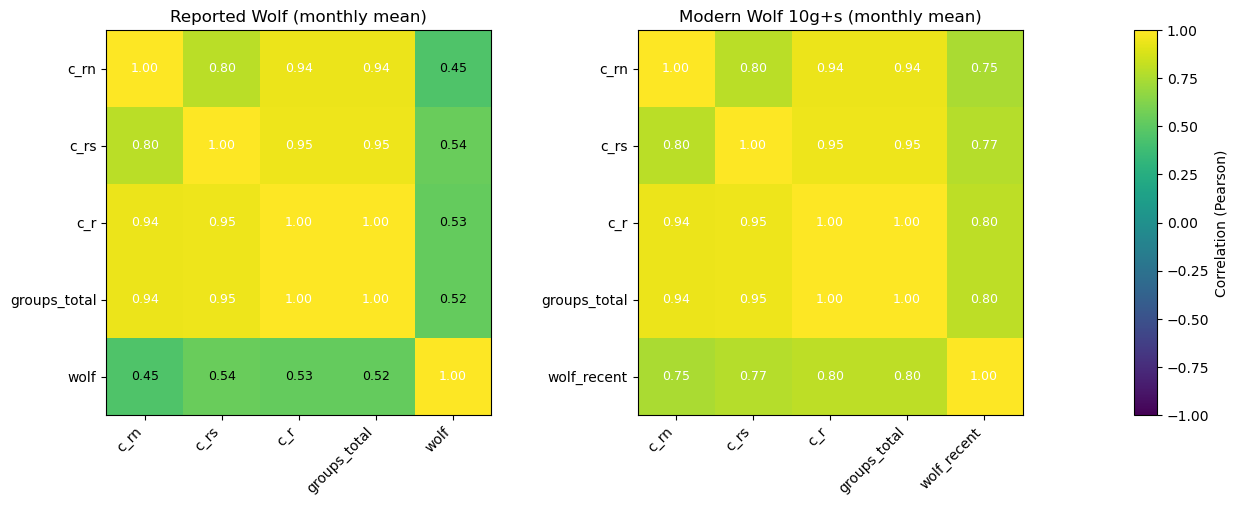


Reported Wolf correlation matrix:
                c_rn   c_rs    c_r  groups_total   wolf
c_rn          1.000  0.796  0.944         0.944  0.450
c_rs          0.796  1.000  0.951         0.951  0.542
c_r           0.944  0.951  1.000         1.000  0.527
groups_total  0.944  0.951  1.000         1.000  0.525
wolf          0.450  0.542  0.527         0.525  1.000

Recent formula Wolf (10g+s) correlation matrix:
                c_rn   c_rs    c_r  groups_total  wolf_recent
c_rn          1.000  0.796  0.944         0.944        0.750
c_rs          0.796  1.000  0.951         0.951        0.774
c_r           0.944  0.951  1.000         1.000        0.802
groups_total  0.944  0.951  1.000         1.000        0.804
wolf_recent   0.750  0.774  0.802         0.804        1.000


In [52]:
def plot_heatmap(ax, corr, title):
    labels = list(corr.columns)
    im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='viridis')

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # numbers in cells
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            v = corr.iat[i, j]
            ax.text(j, i, f"{v:.2f}",
                    ha='center', va='center',
                    color=('w' if abs(v) > 0.6 else 'k'), fontsize=9)

    ax.set_title(title)
    return im

# --- layout with a dedicated colorbar axis ---
fig = plt.figure(figsize=(14,5))
gs  = fig.add_gridspec(1, 3, width_ratios=[1,1,0.05], wspace=0.25)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
cax = fig.add_subplot(gs[0,2])  # colorbar axis

im1 = plot_heatmap(ax1, corr_reported, "Reported Wolf (monthly mean)")
im2 = plot_heatmap(ax2, corr_modern,   "Modern Wolf 10g+s (monthly mean)")

cb = fig.colorbar(im1, cax=cax)
cb.set_label('Correlation (Pearson)')

plt.tight_layout()
plt.savefig('Heatmap_Sunspot_Wolf_recent_and_old.jpg', dpi=300)
plt.show()

print("\nReported Wolf correlation matrix:\n", corr_reported.round(3))
print("\nRecent formula Wolf (10g+s) correlation matrix:\n", corr_modern.round(3))

# What we are seeng is that in the right image -> Wolf number calculated with recent formula
# show much more higher coorelation with 
# for example we can see in left panel wolf vs counts of 'c_rn' and 'c_rs' are relativly average 0.45 - 0.54
# on the right panel same correlation wolf vs counts of 'c_rn' and 'c_rs' are jumping very high 0.75 - 0.77
# this is exactly what we are expecting as Wolf number is presented as direct linear combination of sun spots and 
# formed groups of these spots
# drugite counts are almost collinear for both heat maps.

# So the conclusion that we can make is that dataset contains reaidngs for Wolf number
# which are calculated in some old fashioin firmula, and the result of this is shown 
# as very low correlation between sun spots and gropus of spots in both hemisphere and the Wolf number
# And as we know from theory, thya re highly corelated, which measn as much spots and groups we have, 
# Wolf is increasing...

# we can show the sun spot group distribution

In [53]:
solarData[['c_rn', 'c_rs', 'c_r']].describe()

,c_rn,c_rs,c_r
count,3441.0,3447.0,3449.0
mean,6.176983,7.291268,13.463613
std,8.561053,9.345027,31.598113
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,12.0,12.0,0.0
max,59.0,67.0,192.0


# How can we interpret what we’re seeing
# Mean:
# c_rn (Northern hemisphere): 6.18
# c_rs (Southern hemisphere): 7.29
# c_r (total groups): 13.46
# - On average, more groups are observed in the Southern hemisphere.

# Standard deviation (std):
# c_r is very large (31.6), which means there might be high variability between observations—some days have many groups, others almost none.

# Minimum and 25% / median:
# Many observations are 0 (for c_rn and c_rs, both the 25th percentile and the median (50%) are 0).
# This may mean there are many days with no observed sunspot groups.

# Maximum and 75% quantile:
# Very high maximums are observed (59 and 67), which means strong solar activity on certain days.

# We have to mention that for c_r the 75% quantile is 0. This shows that a large number of days have low activity.


# we will try to check and prove out hypothesis about Wolf number and if it was just calculated as  
# a simple sum of sun spot groups and sun spots


In [54]:
solarData['wolf_alt'] = (
    solarData['c_rn'].fillna(0) +
    solarData['c_rs'].fillna(0) +
    solarData['c_r'].fillna(0)
)

solarData['wolf_check'] = solarData['wolf'] - solarData['wolf_alt']
print(solarData['wolf_check'].describe())
print(solarData[['wolf','wolf_alt','wolf_check']].head(20))

count       3450.0
mean    -14.433043
std      12.727569
min         -132.0
25%          -18.0
50%          -12.0
75%          -11.0
max           54.0
Name: wolf_check, dtype: Float64
    wolf  wolf_alt  wolf_check
0   22.0        22         0.0
1    0.0        11       -11.0
2   28.0        33        -5.0
3   20.0        28        -8.0
4   38.0        24        14.0
5    0.0        11       -11.0
6   36.0        33         3.0
7    0.0         0         0.0
8   14.0        26       -12.0
9    0.0        12       -12.0
10  12.0        34       -22.0
11   0.0        15       -15.0
12  24.0        41       -17.0
13   0.0        11       -11.0
14  30.0        39        -9.0
15  22.0        26        -4.0
16   0.0        13       -13.0
17   0.0        11       -11.0
18  34.0        46       -12.0
19   0.0        12       -12.0


In [55]:
inconsistent = solarData[solarData['wolf_diff'] != 0]
print(inconsistent.sample(10))

           date   no n_s  c_rn  c_rs  c_r   wolf                notes  \
1047 1857-10-05  187   N    12     0    0    0.0                  NaN   
73   1854-03-11   26   S     0    13   47   45.0                  NaN   
1449 1858-07-12  296   S     0    24    0    0.0  See note for 8 Jul.   
2247 1860-03-08  655   N    29     0    0    0.0                  NaN   
2436 1860-05-05  707   N    17     0    0    0.0                  NaN   
2516 1860-05-24  719   S     0    15    0    0.0                  NaN   
2587 1860-06-22  748   N    11     0  119  133.0                  NaN   
1895 1859-08-21  512   N    20     0    0    0.0                  NaN   
2394 1860-04-25  697   N    13     0    0    0.0                  NaN   
2905 1860-09-11  816   N    16     0    0    0.0                  NaN   

     date_original  invalid_date  wolf_expected  wolf_diff  wolf_alt  \
1047    5 Oct 1857         False            120     -120.0        12   
73     11 Mar 1854         False            177     

In [56]:
daily = (solarData.groupby('date')
         .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
              c_rs=('c_rs', lambda s: s.sum(min_count=1)),
              c_r =('c_r',  lambda s: s.sum(min_count=1)),
              # take the nonzero Wolf of the day if present, else NaN
              wolf=('wolf', lambda s: s.replace(0, np.nan).max()))
         .dropna(how='all'))

daily['groups_total'] = daily[['c_rn','c_rs']].sum(axis=1, min_count=1)
daily['W_modern']     = 10*daily['groups_total'].fillna(0) + daily['c_r'].fillna(0)
daily['diff_modern']  = daily['wolf'] - daily['W_modern']
daily['g_plus_s']     = daily['groups_total'].fillna(0) + daily['c_r'].fillna(0)
daily['diff_gs']      = daily['wolf'] - daily['g_plus_s']

print(daily[['diff_modern','diff_gs']].describe())

       diff_modern    diff_gs
count        858.0      858.0
mean   -538.180653 -57.037296
std     439.788759  53.812055
min        -1963.0     -282.0
25%         -892.0      -94.0
50%         -377.5      -36.0
75%         -151.0      -14.0
max           35.0       35.0


In [57]:
solarData['wolf_corrected'] = solarData['wolf']

mask_missing = solarData['wolf_corrected'].isna() | (solarData['wolf_corrected'] == 0)
solarData.loc[mask_missing, 'wolf_corrected'] = solarData.loc[mask_missing, 'wolf_alt']

In [58]:
daily_wolf = (
    solarData.groupby('date')['wolf_corrected']
    .mean()
    .to_frame()
    .rename(columns={'wolf_corrected':'wolf'})
)

In [59]:
date_range = pd.date_range(daily_wolf.index.min(),
                           daily_wolf.index.max(), freq='D')
daily_wolf = daily_wolf.reindex(date_range)
daily_wolf.index.name = 'date'

In [60]:
daily_wolf['wolf_interp'] = daily_wolf['wolf'].interpolate()

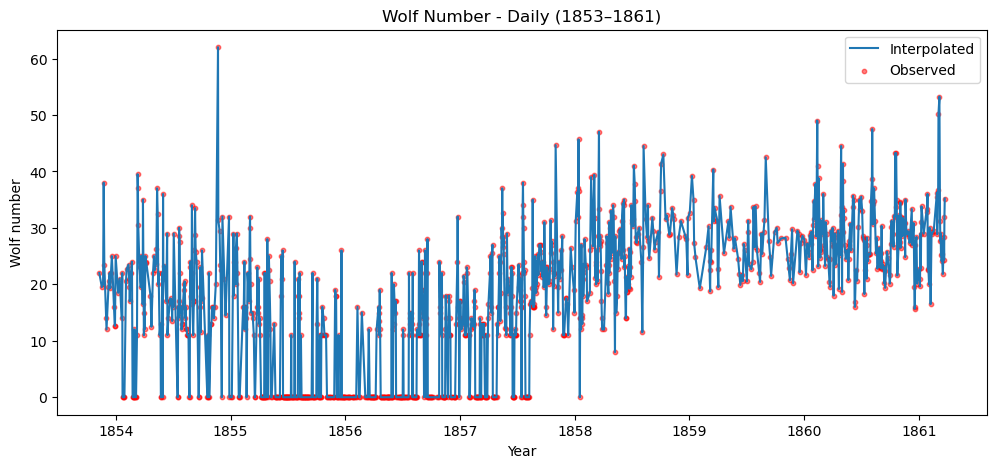

In [61]:
plt.figure(figsize=(12,5))
plt.plot(daily_wolf.index, daily_wolf['wolf_interp'], label='Interpolated')
plt.scatter(daily_wolf.index, daily_wolf['wolf'], s=10, alpha=0.5, label='Observed', c = "r")
plt.title("Wolf Number - Daily (1853–1861)")
plt.ylabel("Wolf number")
plt.xlabel("Year")
plt.legend()
plt.savefig('Wofl_daily.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\2444084105.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_wolf = daily_wolf['wolf_interp'].resample('M').mean()


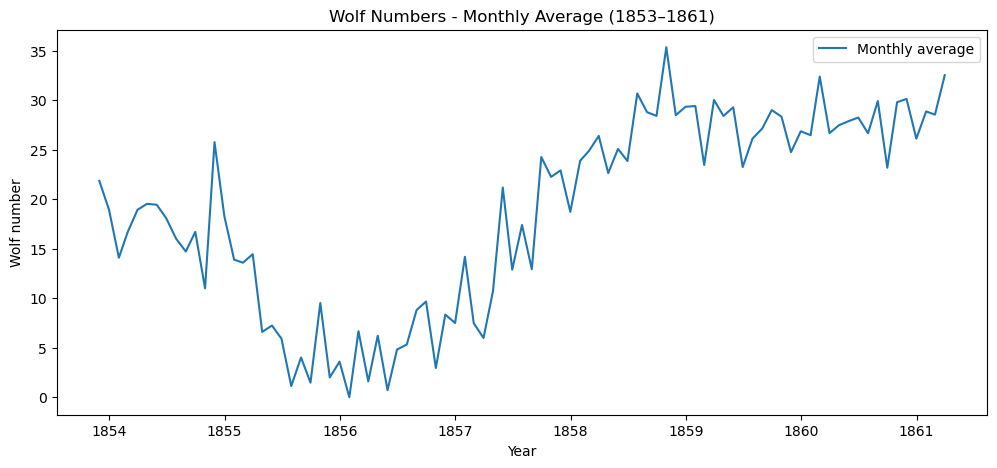

In [62]:
monthly_wolf = daily_wolf['wolf_interp'].resample('M').mean()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(monthly_wolf.index, monthly_wolf, label='Monthly average', color='tab:blue')
plt.title("Wolf Numbers - Monthly Average (1853–1861)")
plt.ylabel("Wolf number")
plt.xlabel("Year")
plt.legend()
plt.savefig('Wofl_monthly.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\1110555918.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()


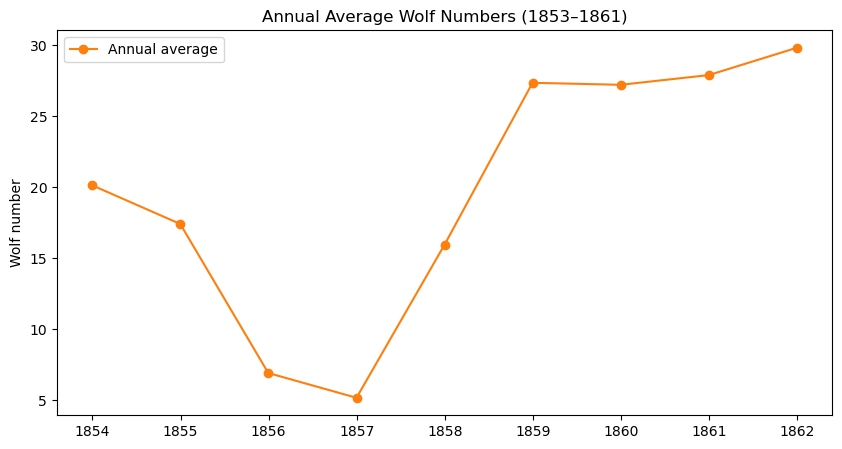

In [63]:
annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()

plt.figure(figsize=(10,5))
plt.plot(annual_wolf.index, annual_wolf, marker='o', color='tab:orange', label='Annual average')
plt.title("Annual Average Wolf Numbers (1853–1861)")
plt.ylabel("Wolf number")
plt.legend()
plt.savefig('Wofl_daily.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\1711219701.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()


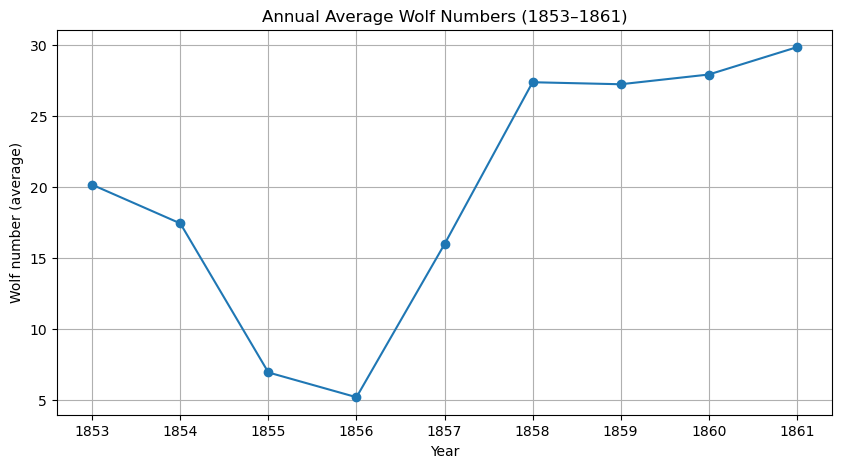

In [64]:
annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()

plt.figure(figsize=(10,5))
plt.plot(annual_wolf.index.year, annual_wolf.values, marker='o')
plt.title("Annual Average Wolf Numbers (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number (average)")
plt.grid(True)
plt.show()

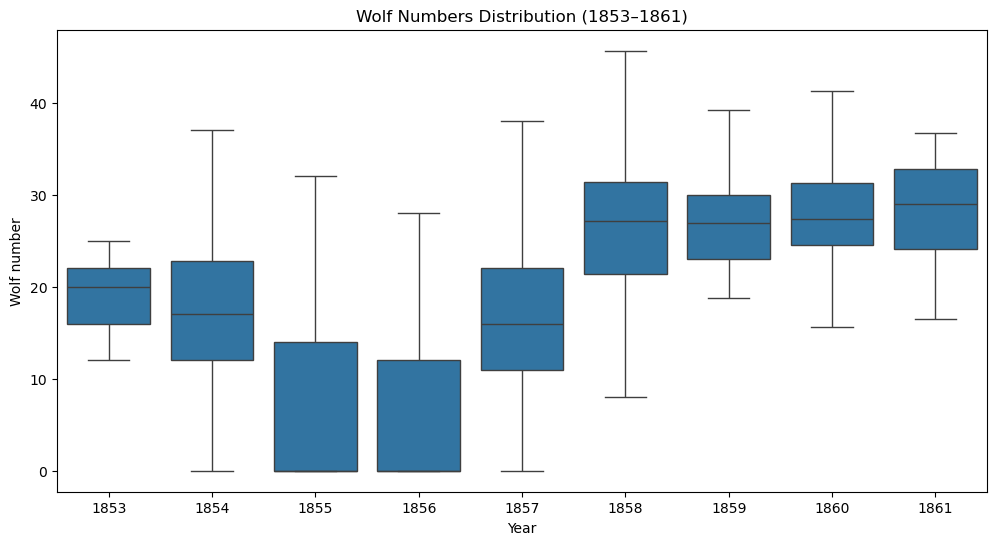

In [65]:
import seaborn as sns

# Prepare dataframe with year extracted
df_yearly = daily_wolf.copy()
df_yearly = df_yearly.reset_index()
df_yearly['year'] = df_yearly['date'].dt.year

plt.figure(figsize=(12,6))
sns.boxplot(x='year', y='wolf', data=df_yearly, showfliers=False)
plt.title("Wolf Numbers Distribution (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number")
plt.savefig('Wofl_daily_dist.jpg', dpi=300) 
plt.show()

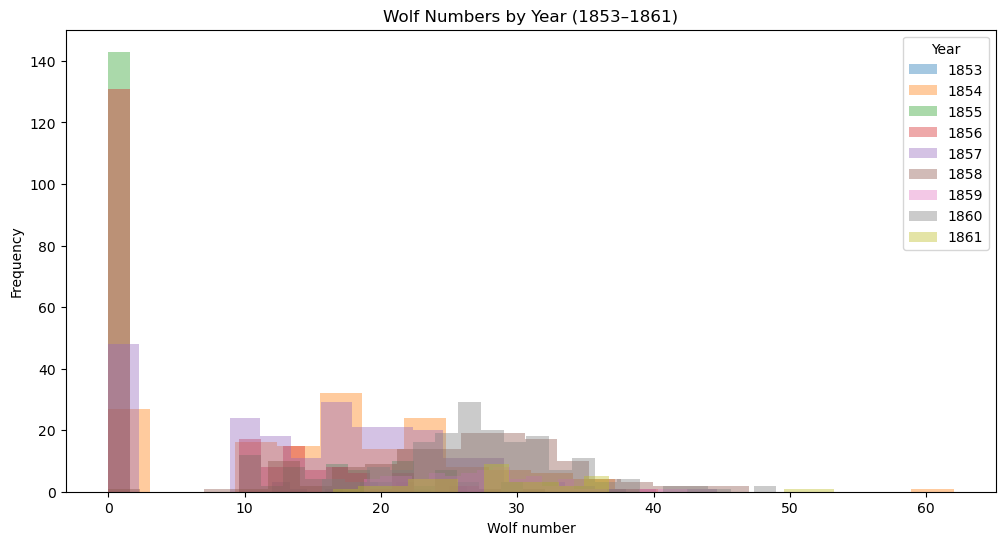

In [66]:
plt.figure(figsize=(12,6))
df_yearly.groupby('year')['wolf'].plot(kind='hist', alpha=0.4, bins=20, legend=True)
plt.title("Wolf Numbers by Year (1853–1861)")
plt.xlabel("Wolf number")
plt.ylabel("Frequency")
plt.legend(title='Year')
plt.savefig('Wofl_histogram.jpg', dpi=300) 
plt.show()

# The average solar activity, the variation between the northern and southern hemispheres, and the maximum and minimum values.

# as those aew just a numbers, we can try to present them as percentage
# as well as we can show the number of days with now active solar groups observerd

In [67]:
NortSun_zero_groups = (solarData['c_rn'] == 0).sum()
print(NortSun_zero_groups)

2069


In [68]:
SouthSun_zero_groups = (solarData['c_rs'] == 0).sum()
print(SouthSun_zero_groups)

1856


In [69]:
TotalDays_zero_groups = (solarData['c_r'] == 0).sum()
print(TotalDays_zero_groups)

2595


In [70]:
total_days = len(solarData)
percent_north = NortSun_zero_groups / total_days * 100
percent_south = SouthSun_zero_groups / total_days * 100
percent_total = TotalDays_zero_groups / total_days * 100

print(f"Процент дни без групи в северното полукълбо: {percent_north:.2f}%")
print(f"Процент дни без групи в южното полукълбо: {percent_south:.2f}%")
print(f"Процент дни без групи общо: {percent_total:.2f}%")

Процент дни без групи в северното полукълбо: 59.97%
Процент дни без групи в южното полукълбо: 53.80%
Процент дни без групи общо: 75.22%


In [71]:
daily = (solarData.groupby('date')
         .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
              c_rs=('c_rs', lambda s: s.sum(min_count=1)),
              c_r =('c_r',  lambda s: s.sum(min_count=1)))
         .reset_index())

# 2) Hemisphere-specific "zero" rates among days that were actually observed
p_north_zero = daily.loc[daily.c_rn.notna(), 'c_rn'].eq(0).mean() * 100
p_south_zero = daily.loc[daily.c_rs.notna(), 'c_rs'].eq(0).mean() * 100

# 3) Overall "zero groups" (strict: only days with BOTH hemispheres observed)
both_obs = daily.c_rn.notna() & daily.c_rs.notna()
p_zero_groups_strict = ((daily.loc[both_obs, 'c_rn'] + daily.loc[both_obs, 'c_rs']).eq(0)
                        .mean() * 100)

# 4) Overall "zero groups" (lenient: assume missing = 0)  ← may overestimate zeros
p_zero_groups_lenient = ((daily['c_rn'].fillna(0) + daily['c_rs'].fillna(0)).eq(0)
                         .mean() * 100)

# 5) Zero *spots* days (if you want this too; different concept)
p_zero_spots = daily.loc[daily.c_r.notna(), 'c_r'].eq(0).mean() * 100

In [72]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected'],
      dtype='object')

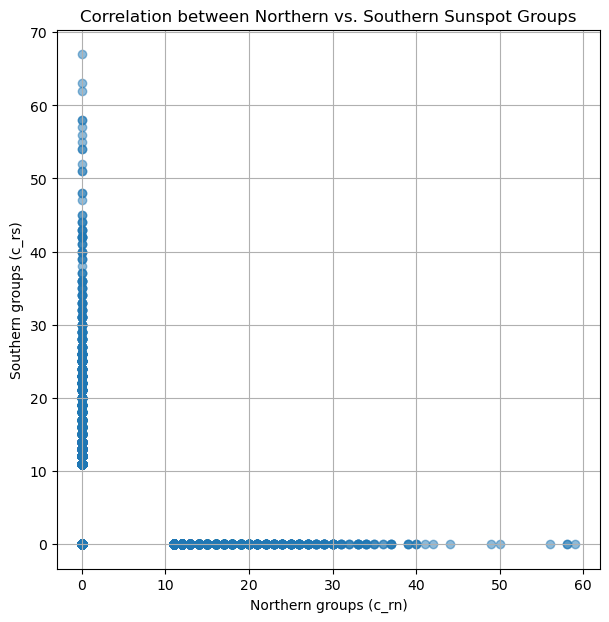

In [73]:
plt.figure(figsize=(7,7))
plt.scatter(solarData['c_rn'], solarData['c_rs'], alpha=0.5)
plt.xlabel("Northern groups (c_rn)")
plt.ylabel("Southern groups (c_rs)")
plt.title("Correlation between Northern vs. Southern Sunspot Groups")
regression=True
plt.grid(True)
plt.savefig('Wofl_N_vs_S_corr.jpg', dpi=300) 
plt.show()

# southern groups (c_rs) vs northern groups (c_rn) from the raw rows from our dataset
# many of the rows represent only one hemisphere which means that the “other” hemisphere is recorded as 0 for that row.
# and this is why we have this L shaped plot: a vertical band at c_rn = 0 (only southrows) and a horizontal band at c_rs = 0 (only north rows), even when both hemispheres were active on that same day but in different rows.

# we can try to agregate to one row per day so we can have more representitive plot of groups in 
# hemispheres

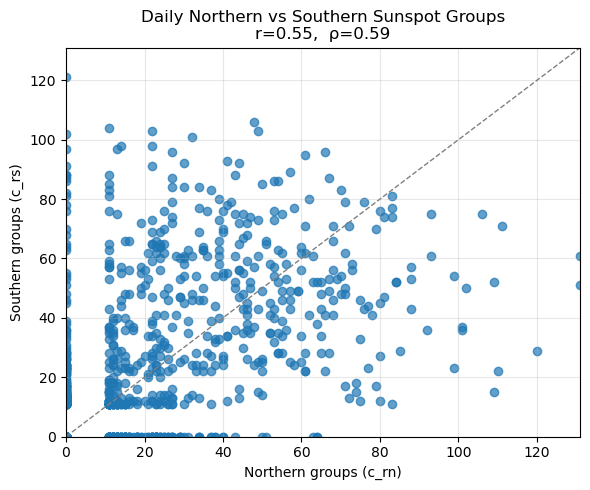

In [74]:
daily = (solarData.groupby('date')[['c_rn','c_rs']]
         .sum(min_count=1)
         .dropna(how='all'))

# Compute quick correlations
pearson  = daily[['c_rn','c_rs']].corr().iloc[0,1]
spearman = daily[['c_rn','c_rs']].corr(method='spearman').iloc[0,1]

plt.figure(figsize=(6,5))
plt.scatter(daily['c_rn'], daily['c_rs'], alpha=0.7)

xymax = max(daily['c_rn'].max(), daily['c_rs'].max())
plt.plot([0, xymax], [0, xymax], ls='--', lw=1, color='gray')

plt.xlabel("Northern groups (c_rn)")
plt.ylabel("Southern groups (c_rs)")
plt.title(f"Daily Northern vs Southern Sunspot Groups\n"
          f"r={pearson:.2f},  ρ={spearman:.2f}")
plt.xlim(0, xymax); plt.ylim(0, xymax)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Wolf_N_vs_S_corr_daily.jpg', dpi=300)
plt.show()

# as we can see now there are many days when both hemispheres had groups.
# we still have vertical and horizontal lines at 0 ,with sounth and north only days
# the cloud is right oriented, which is positive relation 
# we have wide scatter, may be hemispheric assymetry - one of the hemisphere dominates over the other
# As we can see (Spearman) >  (Pearson) - ( 0.59 vs 0.55), which means that the  north–south relation is monotonic, not perfectly linear.
# the sun spots groups lokks like they form together, but their activity  isn not a straight-line fit across all activity levels. 
# this is mostly because of several thing, probably:
# hemispheric assymetry
# outlier (days with no groups formed) are pulling Pearson down
# probably 'heteroscedasticity' - we see spead growing when we have higer activity


In [75]:
pearson  = daily[['c_rn','c_rs']].corr().iloc[0,1]      # linear r
spearman = daily[['c_rn','c_rs']].corr('spearman').iloc[0,1]

both   = (daily.c_rn>0) & (daily.c_rs>0)
north_only = (daily.c_rn>0) & (daily.c_rs==0)
south_only = (daily.c_rs>0) & (daily.c_rn==0)
quiet      = (daily.c_rn==0) & (daily.c_rs==0)

share = {
  'both_active' : both.mean()*100, 
  'north_only'  : north_only.mean()*100,
  'south_only'  : south_only.mean()*100,
  'quiet_days'  : quiet.mean()*100
}
print(pearson, spearman); print(share)

0.551904892087619 0.590836470911072
{'both_active': np.float64(39.724919093851135), 'north_only': np.float64(12.103980503655565), 'south_only': np.float64(16.828478964401295), 'quiet_days': np.float64(31.11291632818847)}


# pearson r = 0.552, spearman ρ = 0.591, this tells us that there is slight positive association between northern and southern daily group counts.
# relationship is monotonic, not perfectly linear ( probably outliers/heteroscedasticity)
# days with no groups in either hemisphere - 31.1% 
# active north hemisphere - 12.1%
# sctive south hemisphere - 16.8%
# both hemisphere are active - 39.7%

# this shows hemispheric asymmetry, with a slight south dominance on one-sided active days.

# we are going to plot the sunspot groups distribution over the years

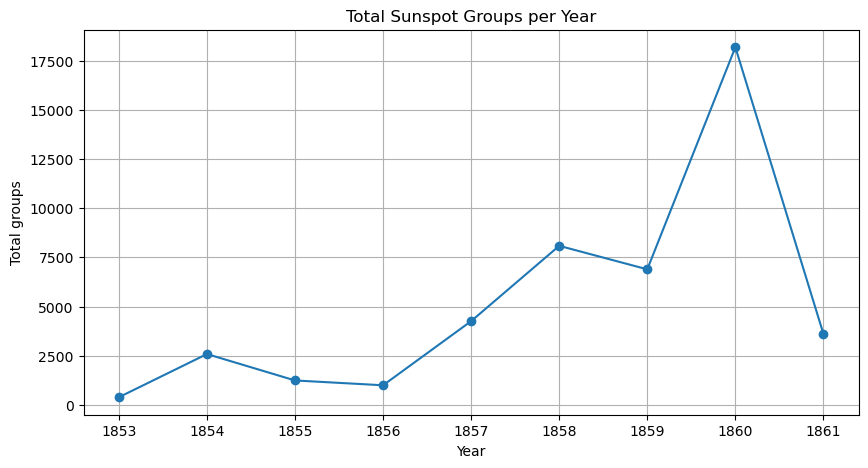

In [76]:
solarData['groups_total'] = solarData['c_rn'].fillna(0) + solarData['c_rs'].fillna(0)

groups_yearly = solarData.groupby(solarData['date'].dt.year)['groups_total'].sum()

plt.figure(figsize=(10,5))
plt.plot(groups_yearly.index, groups_yearly.values, marker='o')
plt.title("Total Sunspot Groups per Year")
plt.xlabel("Year")
plt.ylabel("Total groups")
plt.grid(True)
plt.show()

In [77]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total'],
      dtype='object')

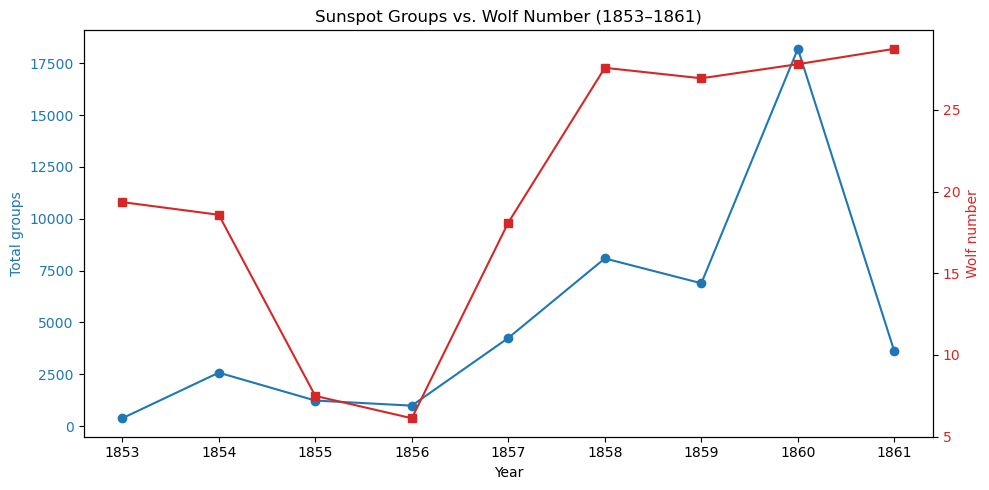

In [78]:
wolf_yearly = solarData.groupby(solarData['date'].dt.year)['wolf_corrected'].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Left axis = total groups
ax1.plot(groups_yearly.index, groups_yearly.values, color='tab:blue', marker='o', label='Total groups')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total groups", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis = Wolf number
ax2 = ax1.twinx()
ax2.plot(wolf_yearly.index, wolf_yearly.values, color='tab:red', marker='s', label='Wolf number')
ax2.set_ylabel("Wolf number", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Sunspot Groups vs. Wolf Number (1853–1861)")
fig.tight_layout()
plt.savefig('Groups_vs_Wofl.jpg', dpi=300) 
plt.show()

# in the graph above we have grouped total sunspots from north and south hemisphere per year
# we can see a minimum in 1855-1856 and sfter that increasing number of sun spots and correlated to that Wolf number
# we see some differences in both lines. this is because Wolf number line - red line is mean, which makes it smooth, compared to blue line which is a sum of all sun spots. Summing makes line to curve more when there are outliers
# what is vere wierd here is the difeewrence in both line in 1861.
# Blue line drops very rapidly, but red line stays relativli constant .
# The reason in probably that red line is mean, and mean for that period might be same, constant
# probably out dataset ends there so that might be the reason why blue line drops that rapidly,
# we can check that 

In [79]:
solarData['date'].tail(5)

3445   1861-03-24
3446   1861-03-24
3447   1861-03-24
3448   1861-03-24
3449          NaT
Name: date, dtype: datetime64[ns]

# As we cxan see our last record is for 1861, march. that is why we have uch a drop for 
# sunspot groups in the above graph.

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\1318436096.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


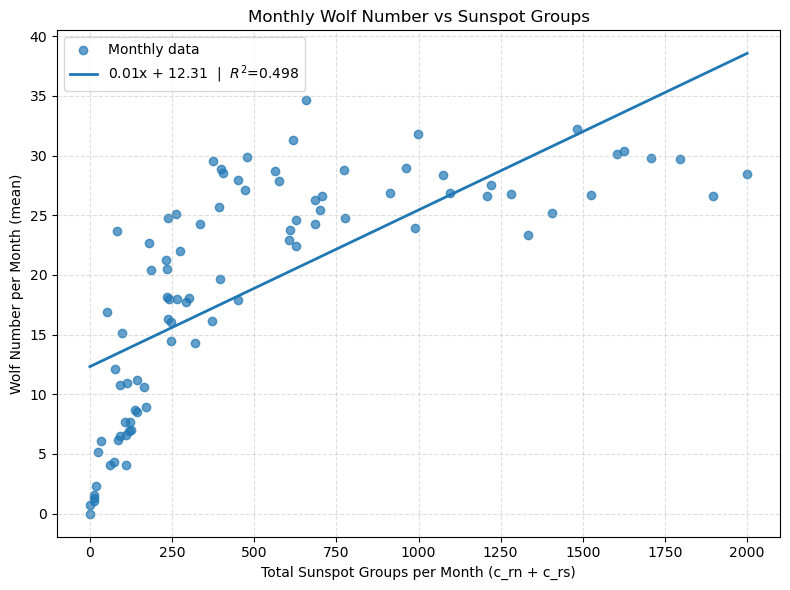

In [80]:
# --- Prep monthly data ---
df = solarData.copy()
df['groups_total'] = df['c_rn'].fillna(0).astype(float) + df['c_rs'].fillna(0).astype(float)

# Use the corrected Wolf column if you created it earlier; else fall back to wolf
wolf_col = 'wolf_corrected' if 'wolf_corrected' in df.columns else 'wolf'

# Monthly aggregates
monthly = (
    df.set_index('date')
      .resample('M')
      .agg({
          'groups_total': 'sum',     # total groups in month
          'c_r': 'sum',              # total spots in month (optional alt X)
          wolf_col: 'mean'           # average Wolf in month
      })
      .dropna(subset=[wolf_col])     # keep months with Wolf data
)

# --- Choose X for the scatter ---
# Option A (recommended): total groups per month
x = monthly['groups_total'].values
x_label = 'Total Sunspot Groups per Month (c_rn + c_rs)'

# If you prefer total *spots* (as in your figure label with c_r), swap:
# x = monthly['c_r'].values
# x_label = 'Total Sunspots per Month (c_r)'

y = monthly[wolf_col].values

# --- Fit simple linear regression y = a*x + b ---
a, b = np.polyfit(x, y, 1)
y_hat = a*x + b

# R^2
ss_res = np.sum((y - y_hat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res/ss_tot

# --- Plot ---
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.7, label='Monthly data')
plt.plot(np.sort(x), (a*np.sort(x) + b), linewidth=2, label=f'{a:.2f}x + {b:.2f}  |  $R^2$={r2:.3f}')
plt.title('Monthly Wolf Number vs Sunspot Groups')
plt.xlabel(x_label)
plt.ylabel('Wolf Number per Month (mean)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\3944154937.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['wolf_corrected']


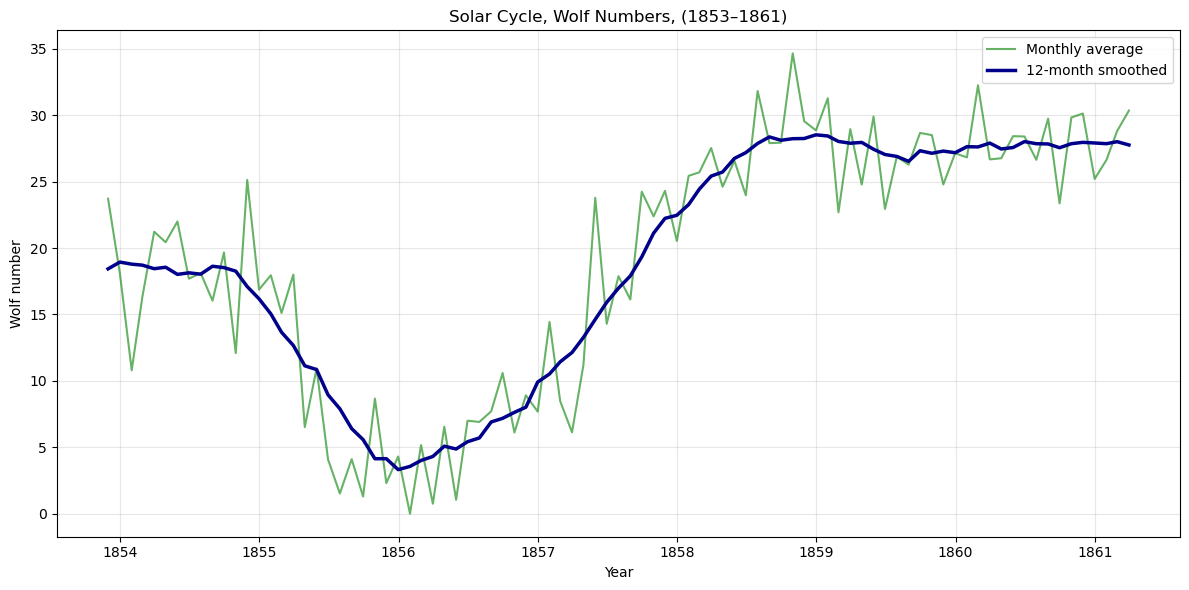

In [81]:
monthly_wolf = (
    solarData.set_index('date')
             .resample('M')['wolf_corrected']
             .mean()
)

# --- apply 12-month rolling average ---
smooth_wolf = monthly_wolf.rolling(window=12, center=True, min_periods=6).mean()

# --- plot ---
plt.figure(figsize=(12,6))
plt.plot(monthly_wolf.index, monthly_wolf, color='green', alpha=0.6, label='Monthly average')
plt.plot(smooth_wolf.index, smooth_wolf, color='darkblue', linewidth=2.5, label='12-month smoothed')

plt.title("Solar Cycle, Wolf Numbers, (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('SmutedSolarCycle.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\4037892833.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


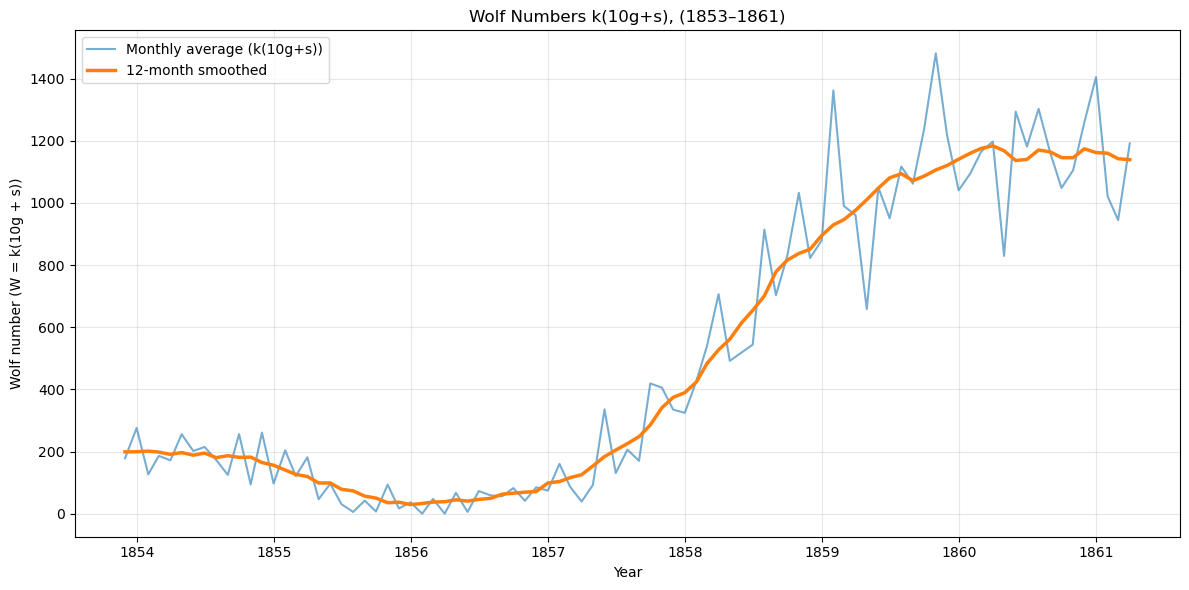

In [82]:
df = solarData.copy()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# --- daily collapse: counts -> SUM per day
daily = (df.groupby('date')
           .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
                c_rs=('c_rs', lambda s: s.sum(min_count=1)),
                c_r =('c_r',  lambda s: s.sum(min_count=1)))
        )

# total groups per day
daily['groups_total'] = daily[['c_rn','c_rs']].sum(axis=1, min_count=1)

# modern Wolf per day: W = 10g + s (keep NaN if both parts missing)
both_missing = daily[['groups_total','c_r']].isna().all(axis=1)
daily['wolf_modern'] = 10*daily['groups_total'].fillna(0) + daily['c_r'].fillna(0)
daily.loc[both_missing, 'wolf_modern'] = np.nan

# --- monthly mean of modern Wolf
monthly_wolf_modern = (daily['wolf_modern']
                       .resample('M')
                       .mean())

# --- 12-month centered smoothing (allow partial at edges)
smooth_modern = monthly_wolf_modern.rolling(window=12, center=True, min_periods=6).mean()

# --- plot
plt.figure(figsize=(12,6))
plt.plot(monthly_wolf_modern.index, monthly_wolf_modern, alpha=0.6, label='Monthly average (k(10g+s))')
plt.plot(smooth_modern.index, smooth_modern, linewidth=2.5, label='12-month smoothed')
plt.title("Wolf Numbers k(10g+s), (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number (W = k(10g + s))")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('SmoothedSolarCycle_modern_Wolf.jpg', dpi=300)
plt.show()

In [83]:
solarData['wolf'].describe()


count    3450.000000
mean       12.472464
std        28.547559
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       184.000000
Name: wolf, dtype: float64

In [84]:
placeholder = (
    (solarData['wolf'] == 0) &
    ((solarData['c_rn'] > 0) | (solarData['c_rs'] > 0) | (solarData['c_r'] > 0))
)
print("Placeholder zeros (%):", placeholder.mean()*100)

# 2) rows that are truly quiet (no groups, no spots, wolf==0)
quiet = (
    (solarData['wolf'] == 0) &
    (solarData['c_rn'].fillna(0) == 0) &
    (solarData['c_rs'].fillna(0) == 0) &
    (solarData['c_r'].fillna(0)  == 0)
)
print("True quiet rows (%):", quiet.mean()*100)

Placeholder zeros (%): 62.22802436901653
True quiet rows (%): 12.89855072463768


In [85]:
df = solarData.copy()
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# collapse to day: sum counts; take the nonzero Wolf if present
daily = (df.groupby('date')
           .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
                c_rs=('c_rs', lambda s: s.sum(min_count=1)),
                c_r =('c_r',  lambda s: s.sum(min_count=1)),
                wolf=('wolf', lambda s: s.replace(0, np.nan).max()))
        )

daily['groups_total'] = daily[['c_rn','c_rs']].sum(axis=1, min_count=1)

# keep wolf=0 for truly quiet days; otherwise NaN if missing
quiet_day = (daily['groups_total'].fillna(0)==0) & (daily['c_r'].fillna(0)==0)
daily.loc[~quiet_day & daily['wolf'].isna(), 'wolf'] = np.nan

print(daily['wolf'].describe())

count    858.000000
mean      49.939394
std       37.109395
min        8.000000
25%       17.000000
50%       38.000000
75%       75.750000
max      184.000000
Name: wolf, dtype: float64


Cleaned daily Wolf summary:
count    858.000000
mean      49.939394
std       37.109395
min        8.000000
25%       17.000000
50%       38.000000
75%       75.750000
max      184.000000
Name: wolf, dtype: float64


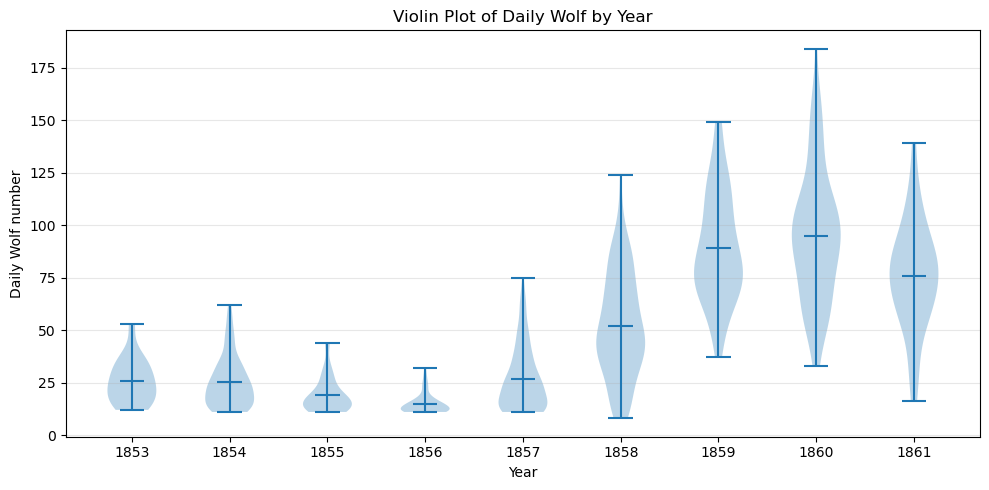

In [86]:
df = solarData.copy()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# Daily aggregation: counts -> sum; Wolf -> use nonzero value if present (else NaN)
daily = (
    df.groupby('date')
      .agg(
          c_rn=('c_rn', lambda s: s.sum(min_count=1)),
          c_rs=('c_rs', lambda s: s.sum(min_count=1)),
          c_r =('c_r',  lambda s: s.sum(min_count=1)),
          wolf=('wolf', lambda s: s.replace(0, np.nan).max())
      )
)

# Total groups per day; mark truly quiet days
daily['groups_total'] = daily[['c_rn','c_rs']].sum(axis=1, min_count=1)
quiet_day = (daily['groups_total'].fillna(0)==0) & (daily['c_r'].fillna(0)==0)

# Cleaned Wolf: keep NaN unless we have a nonzero reported value (or quiet day has explicit 0)
daily.loc[~quiet_day & daily['wolf'].isna(), 'wolf'] = np.nan
clean = daily.dropna(subset=['wolf']).copy()
clean['year'] = clean.index.year

print("Cleaned daily Wolf summary:")
print(clean['wolf'].describe())

# ---------- 3) Violin plot by year ----------
year_order = sorted(clean['year'].unique())
data_by_year = [clean.loc[clean['year']==y, 'wolf'].values for y in year_order]

plt.figure(figsize=(10,5))
plt.violinplot(data_by_year, showmeans=True, showmedians=False, showextrema=True)
plt.xticks(ticks=np.arange(1, len(year_order)+1), labels=year_order)
plt.xlabel('Year')
plt.ylabel('Daily Wolf number')
plt.title('Violin Plot of Daily Wolf by Year')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('violin_cleaned_daily_wolf_by_year.png', dpi=300)
plt.show()

Cleaned daily Wolf summary:
count    858.000000
mean      49.939394
std       37.109395
min        8.000000
25%       17.000000
50%       38.000000
75%       75.750000
max      184.000000
Name: wolf, dtype: float64


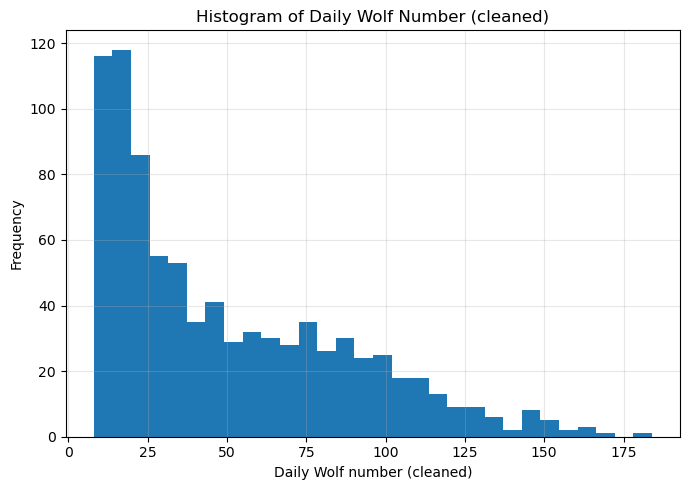

In [87]:
df = solarData.copy()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# Daily aggregation: counts -> sum; Wolf -> use nonzero value if present (else NaN)
daily = (
    df.groupby('date')
      .agg(
          c_rn=('c_rn', lambda s: s.sum(min_count=1)),
          c_rs=('c_rs', lambda s: s.sum(min_count=1)),
          c_r =('c_r',  lambda s: s.sum(min_count=1)),
          wolf=('wolf', lambda s: s.replace(0, np.nan).max())
      )
)

# Total groups per day; mark truly quiet days
daily['groups_total'] = daily[['c_rn','c_rs']].sum(axis=1, min_count=1)
quiet_day = (daily['groups_total'].fillna(0)==0) & (daily['c_r'].fillna(0)==0)

# Cleaned Wolf: keep NaN unless we have a nonzero reported value (or quiet day has explicit 0)
daily.loc[~quiet_day & daily['wolf'].isna(), 'wolf'] = np.nan
clean = daily.dropna(subset=['wolf']).copy()
clean['year'] = clean.index.year

print("Cleaned daily Wolf summary:")
print(clean['wolf'].describe())

# ---------- 2) Histogram ----------
plt.figure(figsize=(7,5))
plt.hist(clean['wolf'].values, bins=30)
plt.xlabel('Daily Wolf number (cleaned)')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Wolf Number (cleaned)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('hist_cleaned_daily_wolf.png', dpi=300)
plt.show()

# наблюдаваме пик близо до 0:
повечето наблюдения имат число на Волф, близко до 0, което означава, че в много дни е имало много ниска или никаква слънчевопетнова активност.
# Дълга дясна опашка:
има по-малко дни с високи числа на Волф, но те се срещат — до около 175 във вашите данни.
# Силно асиметрично разпределение:
типично за броя на слънчевите петна — слънчевият цикъл има много тихи дни и по-малко на брой много активни дни.

# ще се опитаме да плотнем някаква графика, като първо ще ни трябва да групираме по години

In [88]:
solarData['date'] = pd.to_datetime(solarData['date'], errors='coerce')

# ще създадем нова колона в която ше съхраняваме годините на измерването

In [89]:
solarData['year'] = solarData['date'].dt.year

In [90]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [91]:
solarData_fullDataSet = solarData.copy()

In [92]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [93]:
solarData_annual = (
    solarData_fullDataSet
    .groupby('year')
    .sum(numeric_only=True)
    .reset_index()
)

In [94]:
print(solarData_annual)

     year      no  c_rn  c_rs    c_r     wolf  invalid_date  wolf_expected  \
0  1853.0     229   218   164    382    436.0             0           4202   
1  1854.0    9419  1572  1008   2692   3067.0             0          28492   
2  1855.0    7669   682   553   1235   1184.0             0          13585   
3  1856.0    9475   327   663    990    972.0             0          10890   
4  1857.0   53435  1896  2359   4255   4712.0             0          46805   
5  1858.0  129280  2246  5842   8088   7133.0             0          88968   
6  1859.0  212433  3262  3630   6828   6230.0             0          75748   
7  1860.0  846709  9147  9051  18198  16307.0             0         200178   
8  1861.0  189236  1783  1822   3605   2807.0             0          39655   

   wolf_diff  wolf_alt  wolf_check  wolf_corrected  groups_total  
0    -3766.0       764      -328.0           600.0           382  
1   -25425.0      5272     -2205.0          4236.0          2580  
2   -12401.0      

In [95]:
#sunSpot_groups = solarData.groupby('year')[['c_rn', 'c_rs', 'c_r']].sum().reset_index()
sunSpot_groups = solarData_annual.groupby('year')[['c_rn', 'c_rs', 'c_r', 'wolf']].sum().reset_index()

In [96]:
print(sunSpot_groups)

     year  c_rn  c_rs    c_r     wolf
0  1853.0   218   164    382    436.0
1  1854.0  1572  1008   2692   3067.0
2  1855.0   682   553   1235   1184.0
3  1856.0   327   663    990    972.0
4  1857.0  1896  2359   4255   4712.0
5  1858.0  2246  5842   8088   7133.0
6  1859.0  3262  3630   6828   6230.0
7  1860.0  9147  9051  18198  16307.0
8  1861.0  1783  1822   3605   2807.0


In [97]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [98]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [99]:
solarData.head(5)

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date,wolf_expected,wolf_diff,wolf_alt,wolf_check,wolf_corrected,groups_total,year
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False,121,-99.0,22,0.0,22.0,11,1853.0
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False,110,-110.0,11,-11.0,11.0,11,1853.0
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False,132,-104.0,33,-5.0,28.0,11,1853.0
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False,154,-134.0,28,-8.0,20.0,14,1853.0
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False,132,-94.0,24,14.0,38.0,12,1853.0


# Scatter показващ броя на групите на слънчевите петна в северното полукълбо (c_rn) по оста X и броя на групите в южното полукълбо (c_rs) по оста Y, и 
# линия показваща регресията

Наблюдаваме отрицателна корелация (Пирсън r = -0.56)
Коефициентът на корелация на Пирсън -0.56 показва умерена отрицателна връзка между броя на групите слънчеви петна в северното и южното полукълбо.

С други думи — когато броят на групите на север се увеличава, броят на групите на юг има тенденция да намалява, и обратно.

Разпределение на точките
Повечето точки са струпани близо до x = 0 (малък брой групи на север) или y = 0 (малък брой групи на юг).
Това предполага, че много от наблюденията имат активност, концентрирана в едно от полукълбата в даден момент.

Линия на регресията
Регресионната линия има отрицателен наклон, в съответствие с отрицателната корелация.
Наклонът ѝ показва колко средно намалява броят на групите в южното полукълбо при увеличаване на броя в северното.

Възможна причина:
Активността на слънчевите петна често премества доминацията между полукълбата през слънчевите цикли — 
понякога северът е по-активен, понякога югът.

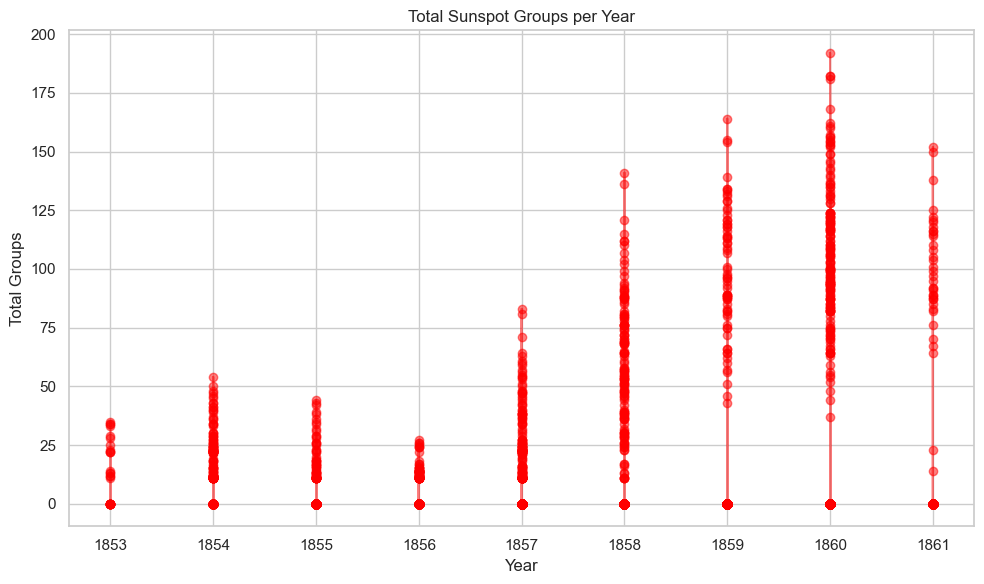

In [100]:
plot_graphs(
    df=solarData,
    plot_type='line',
    x_col='year',
    y_col='c_r',
    title='Total Sunspot Groups per Year',
    xlabel='Year',
    ylabel='Total Groups'
)

In [101]:
solarData = solarData.groupby('year')[['c_rn','c_rs','c_r']].sum().reset_index()
print(solarData)

     year  c_rn  c_rs    c_r
0  1853.0   218   164    382
1  1854.0  1572  1008   2692
2  1855.0   682   553   1235
3  1856.0   327   663    990
4  1857.0  1896  2359   4255
5  1858.0  2246  5842   8088
6  1859.0  3262  3630   6828
7  1860.0  9147  9051  18198
8  1861.0  1783  1822   3605


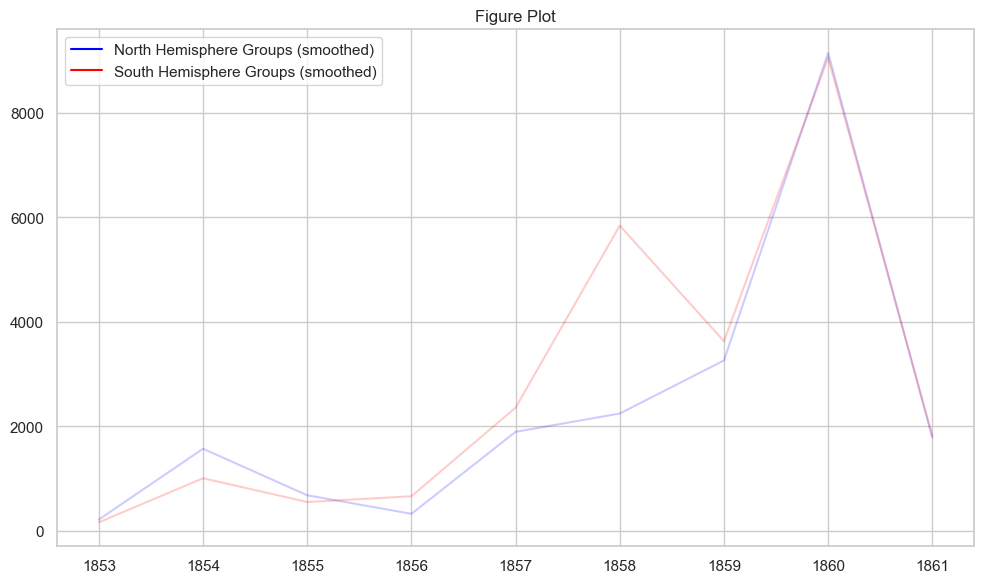

In [102]:
def hemisphere_time_series(data, window=12):
    smooth_north = data['c_rn'].rolling(window=window, center=True).mean()
    smooth_south = data['c_rs'].rolling(window=window, center=True).mean()

    plt.plot(data['year'], smooth_north, label='North Hemisphere Groups (smoothed)', color='blue')
    plt.plot(data['year'], smooth_south, label='South Hemisphere Groups (smoothed)', color='red')

    # 
    plt.plot(data['year'], data['c_rn'], color='blue', alpha=0.2)
    plt.plot(data['year'], data['c_rs'], color='red', alpha=0.2)

    plt.legend()
    plt.ylabel('Groups')
    plt.xlabel('Year')
    plt.title(f'Hemisphere Sunspot Groups Over Time (Smoothed {window} pts)')
    plt.grid(True)

plot_graphs(
    solarData,
    plot_type='figure',
    custom_plot_func=lambda df: hemisphere_time_series(df, window=12)
)

In [103]:
solarData.columns

Index(['year', 'c_rn', 'c_rs', 'c_r'], dtype='object')

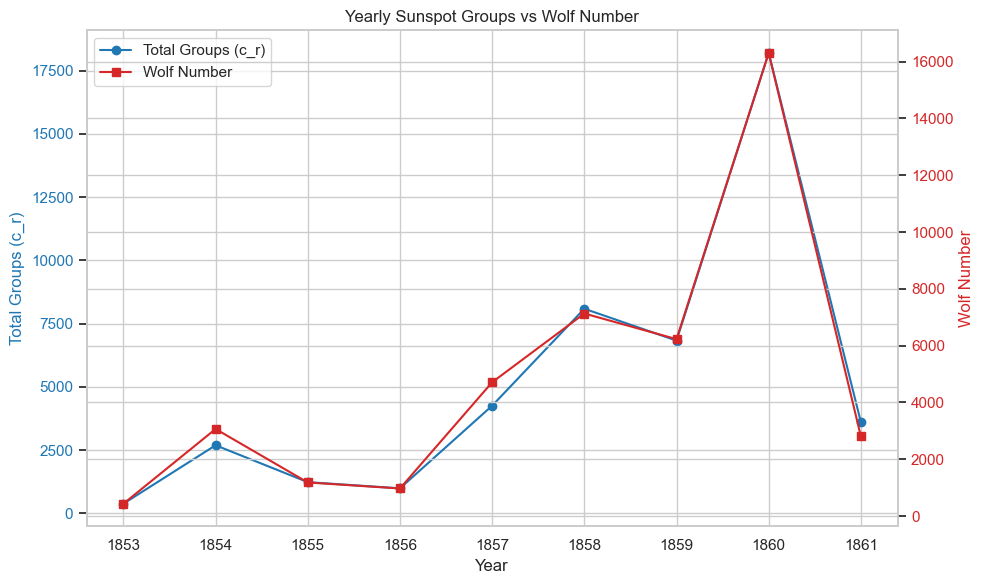

In [104]:
def plot_wolf_vs_cr(data):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot total groups (c_r) on left y-axis
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Total Groups (c_r)", color="tab:blue")
    ax1.plot(data['year'], data['c_r'], color="tab:blue", marker='o', label="Total Groups (c_r)")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    # Second y-axis for Wolf numbers
    ax2 = ax1.twinx()
    ax2.set_ylabel("Wolf Number", color="tab:red")
    ax2.plot(data['year'], data['wolf'], color="tab:red", marker='s', label="Wolf Number")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    # Titles & legends
    plt.title("Yearly Sunspot Groups vs Wolf Number")
    fig.tight_layout()

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.6)
    plt.savefig('YearlySunSpots_vs_Wofl.jpg', dpi=300) 
    plt.show()

# Run it
plot_wolf_vs_cr(sunSpot_groups)

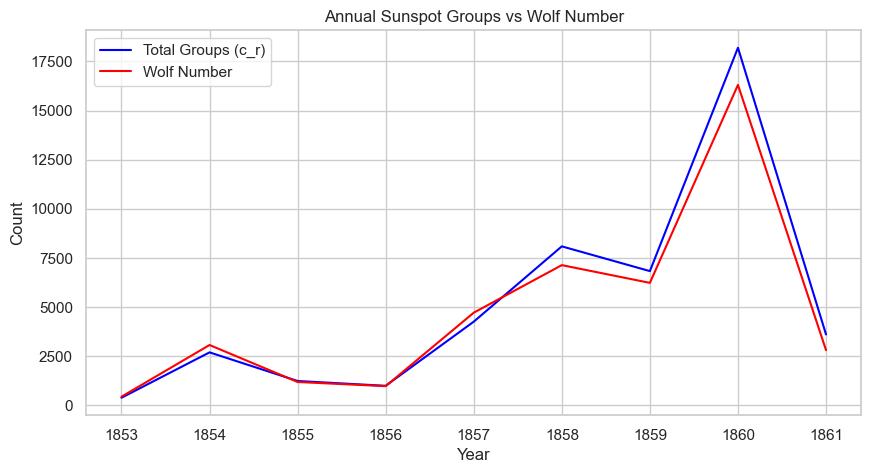

In [105]:
plt.figure(figsize=(10,5))
plt.plot(sunSpot_groups['year'], sunSpot_groups['c_r'], label='Total Groups (c_r)', color='blue')
plt.plot(sunSpot_groups['year'], sunSpot_groups['wolf'], label='Wolf Number', color='red')
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Annual Sunspot Groups vs Wolf Number")
plt.legend()
plt.grid(True)
plt.show()

In [106]:
summary_stats = sunSpot_groups.describe().T  # .T transposes for better view
summary_stats['median'] = sunSpot_groups.median()
summary_stats = summary_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]

summary_stats

,mean,median,std,min,25%,50%,75%,max
year,1857.0,1857.0,2.738613,1853.0,1855.0,1857.0,1859.0,1861.0
c_rn,2348.111111,1783.0,2729.349806,218.0,682.0,1783.0,2246.0,9147.0
c_rs,2788.0,1822.0,2956.832596,164.0,663.0,1822.0,3630.0,9051.0
c_r,5141.444444,3605.0,5548.576802,382.0,1235.0,3605.0,6828.0,18198.0
wolf,4760.888889,3067.0,4919.879176,436.0,1184.0,3067.0,6230.0,16307.0


In [107]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [108]:
# 1) Visual: residuals vs fitted
plt.scatter(yhat, resid, alpha=0.7)
plt.axhline(0, ls='--')
plt.xlabel('Fitted'); plt.ylabel('Residuals'); plt.title('Residuals vs Fitted')
plt.grid(True, alpha=0.3); plt.show()

# 2) Breusch–Pagan (tests variance ~ function of X)
exog = sm.add_constant(X)
bp_stat, bp_p, f_stat, f_p = het_breuschpagan(resid, exog)
print(f"Breusch–Pagan: LM={bp_stat:.2f}, p={bp_p:.3f} | F={f_stat:.2f}, p={f_p:.3f}")

# 3) White test (more general form)
w_stat, w_p, wf_stat, wf_p = het_white(resid, exog)
print(f"White test: LM={w_stat:.2f}, p={w_p:.3f} | F={wf_stat:.2f}, p={wf_p:.3f}")

# 4) Nonparametric: is |resid| related to fitted?
rho, p = spearmanr(np.abs(resid), yhat)
print(f"Spearman(|resid|, fitted): rho={rho:.2f}, p={p:.3f}")

# 5) Variance across fitted bins (Levene)
q = pd.qcut(yhat, 4, labels=False, duplicates='drop')
groups = [resid[q==i] for i in np.unique(q)]
W, pL = levene(*groups, center='median')
print(f"Levene across fitted quartiles: W={W:.2f}, p={pL:.3f}")

NameError: name 'yhat' is not defined

Всяка синя точка представлява един месец обобщени данни за слънчевата активност.

Х-ос: Общият брой групи слънчеви петна (c_r), наблюдавани през този месец.
Y-ос: Съответният месечен брой на Волф (традиционен индекс за слънчева активност).

Линeйна регресия -> най-добре пасващата линейна регресия:

Наклон (0.87): За всяка допълнителна група слънчеви петна в рамките на месец, броят на Волф нараства средно с около 0.87 единици.
Отсечка (28.72): Дори при 0 групи слънчеви петна, броят на Волф ще е около 29. Тази базова стойност идва от начина, по който се изчислява индексът на Волф (той включва и броя на отделните петна, а не само групите).

Стойност на R² (0.976) = 0.976 означава, че 97.6% от изменението в числото на Волф може да се обясни чрез изменението в броя на групите слънчеви петна. Това е изключително силна линейна връзка — c_r и Wolf са почти перфектно корелирани.

Интерпретация:
Можем да кажем, че числото на Волф може да бъде предсказано с висока точност само от броя на групите слънчеви петна.
Малкото разсейване около линията вероятно идва от разликите в броя на отделните петна във всяка група, които са вкл'чени в числото на Wolf, но c_r не.

# Няколко думи като резюме и обосновка на данните които наблюдавахме за слънчевите петна и групирането им в групи

-> Връзка между активността на хемисферите:
Корелацията между групите в Северното полукълбо (c_rn) и групите в Южното полукълбо (c_rs) е отрицателна (r  -0.56)

Това показва, че през наблюдаваните години, когато едно полукълбо става по-активно, другото обикновено е по-малко активно.
Това редуване е съвместимо с известното поведение на слънчевия цикъл, при което активността на слънчевите петна преминава от едно полукълбо към другото с течение на времето.

-> Връзка между общия брой групи и числото на Волф
Общият брой групи (c_r) и числото на Волф (wolf) имат изключително висока корелация (r ≈ 0.96).
Регресионният анализ потвърждава, че над 97% от вариациите в числата на Волф могат да се обяснят само чрез броя на групите слънчеви петна.
Малки отклонения от линията се дължат на факта, че формулата на Волф включва отделни слънчеви петна, а не само групи.

-> Разпределение на числата на Волф
Повечето стойности на Волф са нула или близки до нула (медиана = 0), което означава, че много дни имат малка или никаква активност на слънчевите петна.
Съществува асиметрична дълга дясна опашка до 184, която представлява редки, но изключително активни дни.
Това асиметрично разпределение съответства на модела на слънчевия цикъл — дълги спокойни фази и кратки изблици на висока активност.

-> Тенденции на активността във времето
Годишната агрегация показва големи колебания в общата активност на слънчевите петна.
Пиковите години (например 1860) имат порядъци повече групи и стойности на Волф в сравнение с минималните години (например 1853, 1856).
Това е отличителен белег на ~11-годишния слънчев цикъл, който можем да видим дори в този частичен набор от данни.

-> Качество и пълнота на данните
Колоната invalid_date е нула за всички години — което предполага, че наборът от данни е чист по отношение на обработката на датите.

Въпреки това, липсващи данни могат да съществуват на по-кратки времеви интервали (месеци/дни), затова е необходимо внимателно боравене със стойности NaN при моделирането.

Крайни бележки
Наборът от данни силно подкрепя известните модели в слънчевата физика: редуване на активността между хемисферите, силна линейна връзка между броя на групите и числата на Волф, както и циклично покачване и спад на активността.

In [109]:
monthly_data = (
    solarData_fullDataSet
    .groupby([solarData_fullDataSet['date'].dt.to_period('M')])
    .agg({'c_r':'sum', 'wolf':'mean'})
    .reset_index()
)
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

In [110]:
solarData.columns

Index(['year', 'c_rn', 'c_rs', 'c_r'], dtype='object')

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\2571235458.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


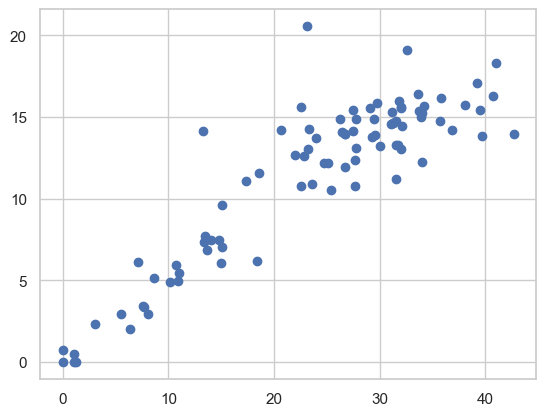

In [111]:
df = solarData_fullDataSet.copy()
df['groups_total'] = df['c_rn'].fillna(0) + df['c_rs'].fillna(0)

monthly = (
    df.set_index('date')
      .resample('M')
      .agg({'groups_total':'mean', 'c_r':'mean', 'wolf':'mean'})
)

monthly['wolf_expected'] = monthly['groups_total'] + monthly['c_r']

plt.scatter(monthly['wolf_expected'], monthly['wolf'])

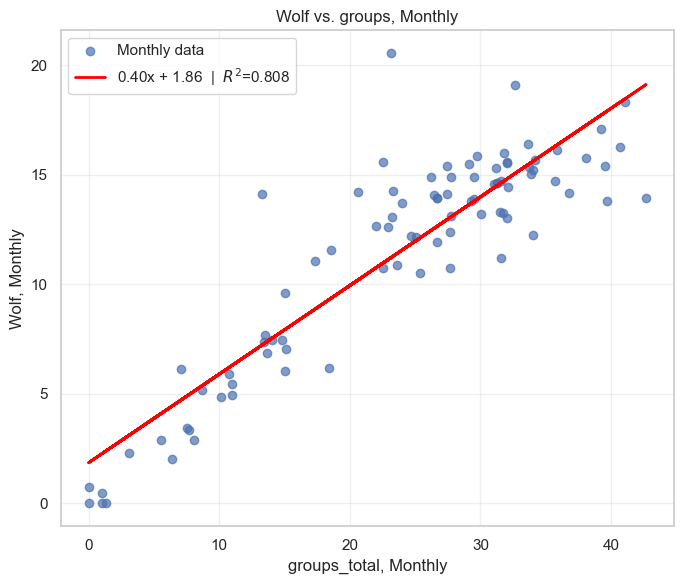

In [112]:
# X = monthly mean of (groups_total + c_r)
X = monthly['wolf_expected'].values.reshape(-1,1)   # your computed formula
y = monthly['wolf'].values                          # reported Wolf number

# Fit regression
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# R²
r2 = model.score(X, y)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(X, y, alpha=0.7, label="Monthly data")
plt.plot(X, y_pred, color='red', linewidth=2,
         label=f"{model.coef_[0]:.2f}x + {model.intercept_:.2f}  |  $R^2$={r2:.3f}")
plt.xlabel("groups_total, Monthly")
plt.ylabel("Wolf, Monthly" )
plt.title("Wolf vs. groups, Monthly")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('WolfVsSunSpots_regression.jpg', dpi=300) 
plt.show()

In [113]:
# X = monthly['groups_total'].values.reshape(-1,1)
# y = monthly_wolf.values  # monthly mean Wolf
model = LinearRegression().fit(X, y)
yhat = model.predict(X)
resid = y - yhat

print("Residual mean (≈0):", resid.mean())
print("Residual median (≈0):", np.median(resid))
print("Above line:", (resid>0).sum(), "Below line:", (resid<0).sum())
print("Residual vs x correlation (should be ~0 if no pattern):",
      np.corrcoef(resid, X.squeeze())[0,1])

Residual mean (≈0): -7.983626244495507e-16
Residual median (≈0): -0.2019511867227477
Above line: 40 Below line: 49


AttributeError: 'FloatingArray' object has no attribute 'squeeze'

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\3262461388.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = (daily.resample('M')


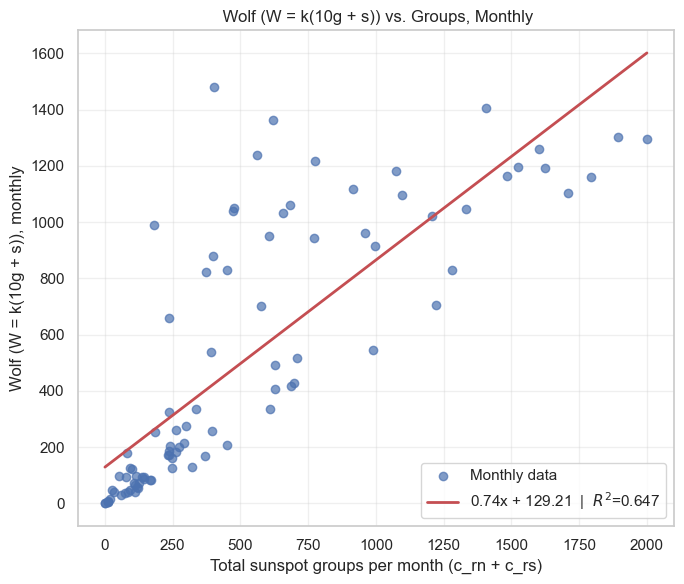

In [125]:
df = solarData_fullDataSet.copy()  # <-- replace with the raw daily df that has 'date'

# 1) ensure datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# 2) collapse to 1 row/day: sum counts
daily = (df.groupby('date')
           .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
                c_rs=('c_rs', lambda s: s.sum(min_count=1)),
                c_r =('c_r',  lambda s: s.sum(min_count=1))))

daily['groups_total'] = daily[['c_rn','c_rs']].sum(axis=1, min_count=1)

# modern Wolf per day (W = 10g + s), keep NaN if both parts missing
both_missing = daily[['groups_total','c_r']].isna().all(axis=1)
daily['wolf_modern'] = 10*daily['groups_total'].fillna(0) + daily['c_r'].fillna(0)
daily.loc[both_missing, 'wolf_modern'] = np.nan

# 3) monthly features: counts=sum, Wolf=index-like=mean
monthly = (daily.resample('M')
           .agg(groups_total=('groups_total','sum'),
                wolf_modern=('wolf_modern','mean'))
           .dropna())

# 4) regression + plot
X = monthly['groups_total'].to_numpy().reshape(-1,1)
y = monthly['wolf_modern'].to_numpy()

model = LinearRegression().fit(X, y)
y_pred = model.predict(X); r2 = model.score(X, y)

plt.figure(figsize=(7,6))
plt.scatter(X, y, alpha=0.7, label='Monthly data')
order = np.argsort(X[:,0])
plt.plot(X[order], y_pred[order], 'r', lw=2,
         label=f"{model.coef_[0]:.2f}x + {model.intercept_:.2f}  |  $R^2$={r2:.3f}")
plt.xlabel("Total sunspot groups per month (c_rn + c_rs)")
plt.ylabel("Wolf (W = k(10g + s)), monthly")
plt.title(" Wolf (W = k(10g + s)) vs. Groups, Monthly")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig('ModernWolf_vs_Groups_monthly_regression.png', dpi=300)
plt.show()

In [115]:
solarData.columns

Index(['year', 'c_rn', 'c_rs', 'c_r'], dtype='object')

In [117]:
if 'solarData_fullDataSet' in globals():
    df_daily_src = solarData_fullDataSet.copy()
else:
    # Option B: reload from disk (adjust path/encoding as needed)
    df_daily_src = pd.read_csv(
        r"C:\Users\georgi.petrov\DataScience\00.ExamProject\data\Teague_Table.csv",
        encoding="ISO-8859-1",
        on_bad_lines="skip"
    )
    # TODO: re-apply your earlier column renames/casts so we have 'date','c_rn','c_rs','c_r'

# ensure a real datetime 'date' column exists
if 'date' not in df_daily_src.columns and 'date_original' in df_daily_src.columns:
    df_daily_src['date'] = pd.to_datetime(df_daily_src['date_original'], errors='coerce')

df_daily_src['date'] = pd.to_datetime(df_daily_src['date'], errors='coerce')
df_daily_src = df_daily_src.dropna(subset=['date'])

# keep only the needed columns
cols_needed = ['date','c_rn','c_rs','c_r']
missing = [c for c in cols_needed if c not in df_daily_src.columns]
if missing:
    raise ValueError(f"These required columns are missing from the DAILY data: {missing}")

In [118]:
daily = (df_daily_src
         .groupby('date', as_index=False)[['c_rn','c_rs','c_r']]
         .sum(min_count=1))

north_obs = daily['c_rn'].notna()
south_obs = daily['c_rs'].notna()
both_obs  = north_obs & south_obs
spots_obs = daily['c_r'].notna()

pct_north_zero   = daily.loc[north_obs, 'c_rn'].eq(0).mean()*100
pct_south_zero   = daily.loc[south_obs, 'c_rs'].eq(0).mean()*100
pct_zero_strict  = daily.loc[both_obs, ['c_rn','c_rs']].sum(axis=1).eq(0).mean()*100
pct_zero_lenient = daily[['c_rn','c_rs']].fillna(0).sum(axis=1).eq(0).mean()*100
pct_zero_spots   = daily.loc[spots_obs, 'c_r'].eq(0).mean()*100

print(f"North zero-group days (observed): {pct_north_zero:.2f}%")
print(f"South zero-group days (observed): {pct_south_zero:.2f}%")
print(f"Zero groups (strict; both hemispheres observed): {pct_zero_strict:.2f}%")
print(f"Zero groups (lenient; NaN→0): {pct_zero_lenient:.2f}%")
print(f"Zero *spots* days (observed): {pct_zero_spots:.2f}%")

North zero-group days (observed): 48.01%
South zero-group days (observed): 43.45%
Zero groups (strict; both hemispheres observed): 31.11%
Zero groups (lenient; NaN→0): 31.39%
Zero *spots* days (observed): 31.07%


In [119]:
n_north = daily['c_rn'].notna().sum()
n_south = daily['c_rs'].notna().sum()
n_both  = (daily['c_rn'].notna() & daily['c_rs'].notna()).sum()
n_spots = daily['c_r'].notna().sum()
print(n_north, n_south, n_both, n_spots)

1231 1236 1231 1236


C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\5240418.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily.resample('M').mean().rename('Wolf_MonthlyMean')
C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\5240418.py:50: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly  = daily.resample('Y').mean().rename('Wolf_YearlyMean')


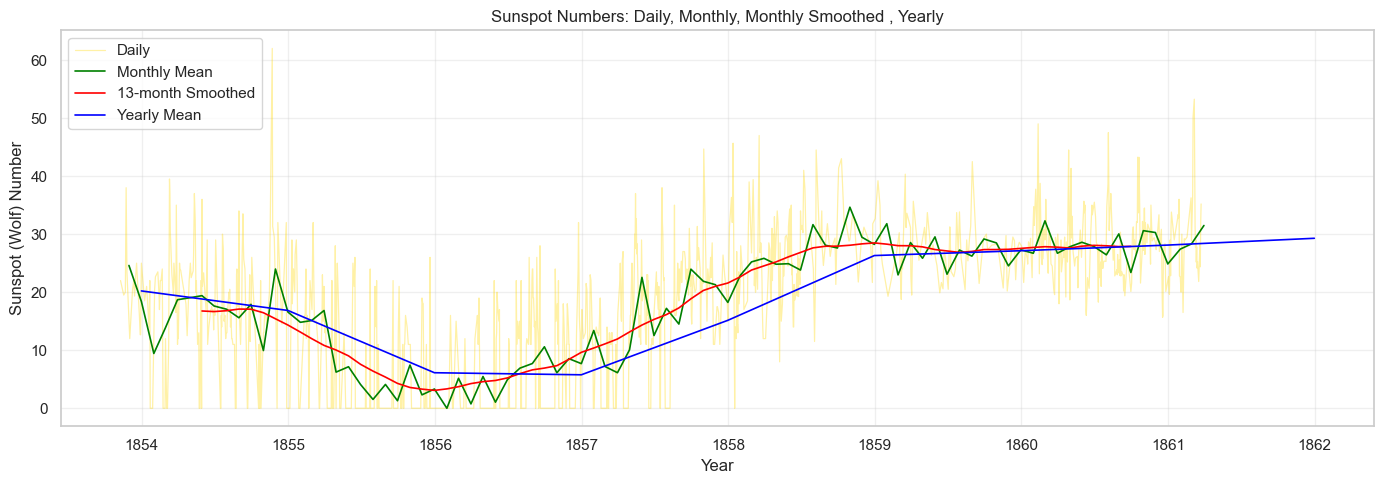

In [120]:
def get_daily_df():
    # (a) try a daily variable already in memory
    for name in ['solarData_fullDataSet', 'solar_daily', 'solarData_raw', 'solarData']:
        if name in globals():
            df = globals()[name].copy()
            # prefer an existing 'date' column
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'], errors='coerce')
                return df[df['date'].notna()]
            # if date is in index
            if isinstance(df.index, pd.DatetimeIndex):
                df = df.reset_index().rename(columns={df.index.name or 'index': 'date'})
                return df[df['date'].notna()]
            # parse from date_original if present
            if 'date_original' in df.columns:
                df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
                return df[df['date'].notna()]
    # (b) reload from disk if nothing usable is in memory
    path = r"C:\Users\georgi.petrov\DataScience\00.ExamProject\data\Teague_Table.csv"
    raw = pd.read_csv(path, encoding="ISO-8859-1", on_bad_lines="skip")
    # rename to your cleaned schema
    raw = raw.rename(columns={
        'Date':'date_original','No.':'no','N / S':'n_s',
        'C / Rn':'c_rn','C / Rs':'c_rs','C / R':'c_r',
        'Wolf':'wolf','Notes':'notes'
    })
    raw['date'] = pd.to_datetime(raw['date_original'], errors='coerce')
    return raw.dropna(subset=['date'])

df = get_daily_df().sort_values('date')

# --- 1) choose Wolf series ---
if 'wolf_corrected' in df.columns:
    wolf_col = 'wolf_corrected'
else:
    # fallback: use reported wolf if present else groups+spots
    if 'wolf' not in df.columns:
        df['wolf'] = np.nan
    if not set(['c_rn','c_rs','c_r']).issubset(df.columns):
        raise KeyError("Missing c_rn/c_rs/c_r; cannot build fallback Wolf.")
    wolf_alt = df[['c_rn','c_rs','c_r']].fillna(0).sum(axis=1)
    df['wolf_use'] = df['wolf'].where(df['wolf'].notna() & (df['wolf']>0), wolf_alt)
    wolf_col = 'wolf_use'

# --- 2) collapse per day (mean; index-like) ---
daily = df.groupby('date')[wolf_col].mean().rename('Wolf_Daily').dropna()

# --- 3) monthly & yearly means ---
monthly = daily.resample('M').mean().rename('Wolf_MonthlyMean')
yearly  = daily.resample('Y').mean().rename('Wolf_YearlyMean')

# --- 4) 13-month smoothed monthly (1/24, 11×1/12, 1/24) ---
w = np.array([1/24] + [1/12]*11 + [1/24])
sm_vals = np.convolve(monthly.values, w, mode='same')
smooth13 = pd.Series(sm_vals, index=monthly.index, name='Wolf_13mSmoothed')
smooth13.iloc[:6] = np.nan; smooth13.iloc[-6:] = np.nan  # trim edge artifacts

# --- 5) plot like your example ---
plt.figure(figsize=(14,5))
plt.plot(daily.index,   daily.values,   linewidth=0.9, color='gold',   alpha=0.35, label='Daily')
plt.plot(monthly.index, monthly.values, linewidth=1.2, color='green',              label='Monthly Mean')
plt.plot(smooth13.index,smooth13.values,linewidth=1.2, color='red',               label='13-month Smoothed')
plt.plot(yearly.index,  yearly.values,  linewidth=1.2, color='blue',         label='Yearly Mean')
plt.title("Sunspot Numbers: Daily, Monthly, Monthly Smoothed , Yearly")
plt.xlabel("Year"); plt.ylabel("Sunspot (Wolf) Number")
plt.savefig('SunSpotsAllInOne.jpg', dpi=300) 
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [121]:
df = solarData.copy()  # <- your yearly table: ['year','c_rn','c_rs','c_r', ...]
# Build features
df['groups_total'] = df[['c_rn','c_rs']].sum(axis=1, min_count=1)

# Pick a Wolf-like column if present, else make a proxy (groups + spots)
if 'wolf_corrected' in df.columns:
    wolf_col = 'wolf_corrected'
elif 'wolf' in df.columns:
    wolf_col = 'wolf'
else:
    df['wolf_proxy'] = df['groups_total'].fillna(0) + df['c_r'].fillna(0)
    wolf_col = 'wolf_proxy'

feat_yearly = df[['c_rn','c_rs','c_r','groups_total', wolf_col]].rename(columns={wolf_col:'wolf'})
corr_yearly = feat_yearly.corr()
print(corr_yearly.round(3))

               c_rn   c_rs    c_r  groups_total   wolf
c_rn          1.000  0.910  0.976         0.975  0.976
c_rs          0.910  1.000  0.979         0.979  0.979
c_r           0.976  0.979  1.000         1.000  1.000
groups_total  0.975  0.979  1.000         1.000  1.000
wolf          0.976  0.979  1.000         1.000  1.000


In [122]:
def get_daily_df():
    for name in ['solarData_fullDataSet', 'solarData']:
        if name in globals():
            df = globals()[name].copy()
            # a) 'date' exists
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'], errors='coerce')
                return df[df['date'].notna()]
            # b) date is in the index
            if isinstance(df.index, pd.DatetimeIndex):
                df = df.reset_index().rename(columns={df.index.name or 'index':'date'})
                return df[df['date'].notna()]
            # c) parse from date_original if present
            if 'date_original' in df.columns:
                df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
                return df[df['date'].notna()]
    raise NameError("No daily dataframe with a 'date' column found (e.g. solarData_fullDataSet).")

solar_daily = get_daily_df().sort_values('date')

# -------- 2) Build features for the heatmap/matrix (monthly) --------
# counts → SUM per month; Wolf (index-like) → MEAN per month
solar_daily['groups_total'] = solar_daily['c_rn'].fillna(0) + solar_daily['c_rs'].fillna(0)
wolf_col = 'wolf_corrected' if 'wolf_corrected' in solar_daily.columns else 'wolf'

feat = (
    solar_daily.set_index('date')
    .resample('M')
    .agg({
        'c_rn': 'sum',
        'c_rs': 'sum',
        'c_r':  'sum',
        'groups_total': 'sum',
        wolf_col: 'mean'
    })
    .rename(columns={wolf_col: 'wolf'})
)

# -------- 3) (Optional) sanity checks that often explain "1.000" everywhere --------
print("groups_total == c_r  ?", feat['groups_total'].equals(feat['c_r']))
print("wolf identical to c_r?", feat['wolf'].equals(feat['c_r']))
print("max |groups_total - c_r|:", (feat['groups_total'] - feat['c_r']).abs().max())

# -------- 4) Correlation matrix to print (matches the heatmap if you plotted from `feat`) --------
corr = feat.corr()
print(corr.round(3))

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\2872109985.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


groups_total == c_r  ? False
wolf identical to c_r? False
max |groups_total - c_r|: 90
               c_rn   c_rs    c_r  groups_total   wolf
c_rn          1.000  0.796  0.944         0.944  0.615
c_rs          0.796  1.000  0.951         0.951  0.719
c_r           0.944  0.951  1.000         1.000  0.706
groups_total  0.944  0.951  1.000         1.000  0.706
wolf          0.615  0.719  0.706         0.706  1.000


In [123]:
a, b = np.polyfit(feat['groups_total'].values, feat['c_r'].values, 1)
print(f"c_r ≈ {a:.3f} * groups_total + {b:.3f}")

c_r ≈ 0.998 * groups_total + 1.679


In [124]:
df = solarData_fullDataSet.copy()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# daily groups and modern Wolf (k=1)
df['groups_total'] = df['c_rn'].fillna(0) + df['c_rs'].fillna(0)
df['W_modern'] = 10*df['groups_total'] + df['c_r'].fillna(0)

# monthly means (the F=16.7·W relation is typically quoted for monthly averages)
monthly = (df.set_index('date')[['W_modern']]
             .resample('M').mean()
             .dropna())

# implied area (cannot be validated without real area data)
monthly['F_implied_MSH'] = 16.7 * monthly['W_modern']
print(monthly.head())

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_5132\701617199.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean()


              W_modern  F_implied_MSH
date                                 
1853-11-30  127.285714    2125.671429
1853-12-31  137.958333    2303.904167
1854-01-31       101.2        1690.04
1854-02-28  124.142857    2073.185714
1854-03-31  117.045455    1954.659091
